In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import sklearn.model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, OrdinalEncoder

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

### Data understanding & cleaning

In [3]:
df=pd.read_csv('train.csv')

In [4]:
df.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

In [5]:
df.shape

(891, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [8]:
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate rows (including first) in the table is: 0


In [9]:
#Starting manupulating dataframe
dfv01=df.copy()

In [10]:
"""Converting features into appropriate data types """
dfv01['PassengerId'] = dfv01['PassengerId'].astype('object')
dfv01['Sex'] = dfv01['Sex'].astype('category')
dfv01['Embarked'] = dfv01['Embarked'].astype('category')
dfv01['Pclass'] = dfv01['Pclass'].astype('category')

In [11]:
dfv01.dtypes

PassengerId      object
Survived          int64
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [12]:
# Descriptive stats for categorical features only.
category_columns = dfv01.select_dtypes(['category']).columns
dfv01[category_columns].describe().T

count unique   top freq
Pclass     891      3     3  491
Sex        891      2  male  577
Embarked   889      3     S  644

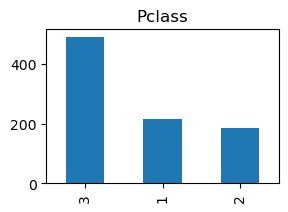

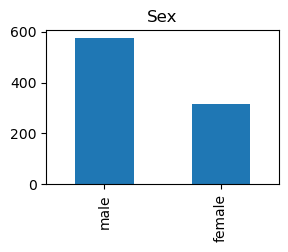

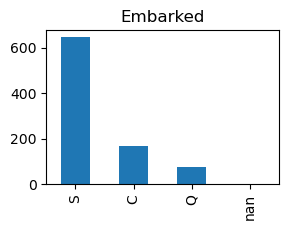

In [13]:
for column in category_columns:
    f = df[column].value_counts(dropna=False).plot(kind='bar', figsize=(3,2), title=column)
    plt.show()

In [14]:
#Fixing "nan" in Embarked with most common location
dfv01['Embarked']=dfv01['Embarked'].fillna('S')

In [15]:
dfv01.describe().T

count       mean        std   min      25%      50%   75%       max
Survived  891.0   0.383838   0.486592  0.00   0.0000   0.0000   1.0    1.0000
Age       714.0  29.699118  14.526497  0.42  20.1250  28.0000  38.0   80.0000
SibSp     891.0   0.523008   1.102743  0.00   0.0000   0.0000   1.0    8.0000
Parch     891.0   0.381594   0.806057  0.00   0.0000   0.0000   0.0    6.0000
Fare      891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292

In [16]:
print(f"Pclass\n{dfv01['Pclass'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Embarked\n{dfv01['Embarked'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")

Pclass
3    55.1%
1    24.2%
2    20.7%
Name: Pclass, dtype: object
Embarked
S    72.5%
C    18.9%
Q     8.6%
Name: Embarked, dtype: object


#### checking distribution of numeric data

In [17]:
print("Kurtosis value of the Fare attribute",kurtosis(dfv01.Fare, axis=0, bias=True))
print("Skewness value of the Fare attribute",skew(dfv01.Fare, axis=0, bias=True))

Kurtosis value of the Fare attribute 33.20428925264474
Skewness value of the Fare attribute 4.7792532923723545


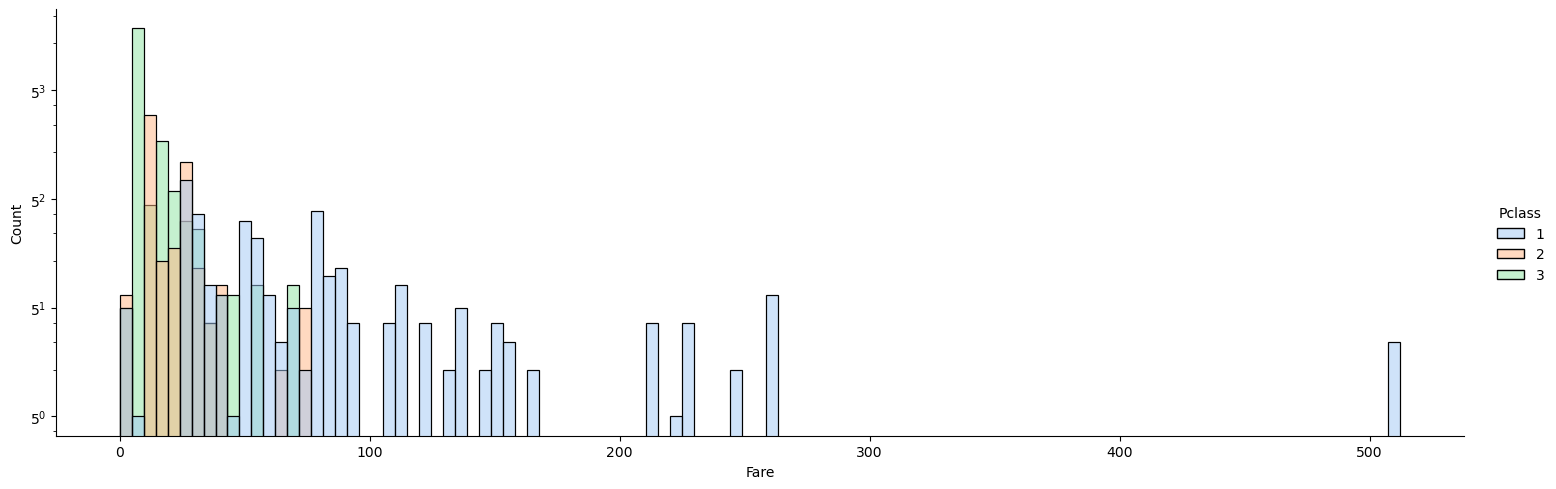

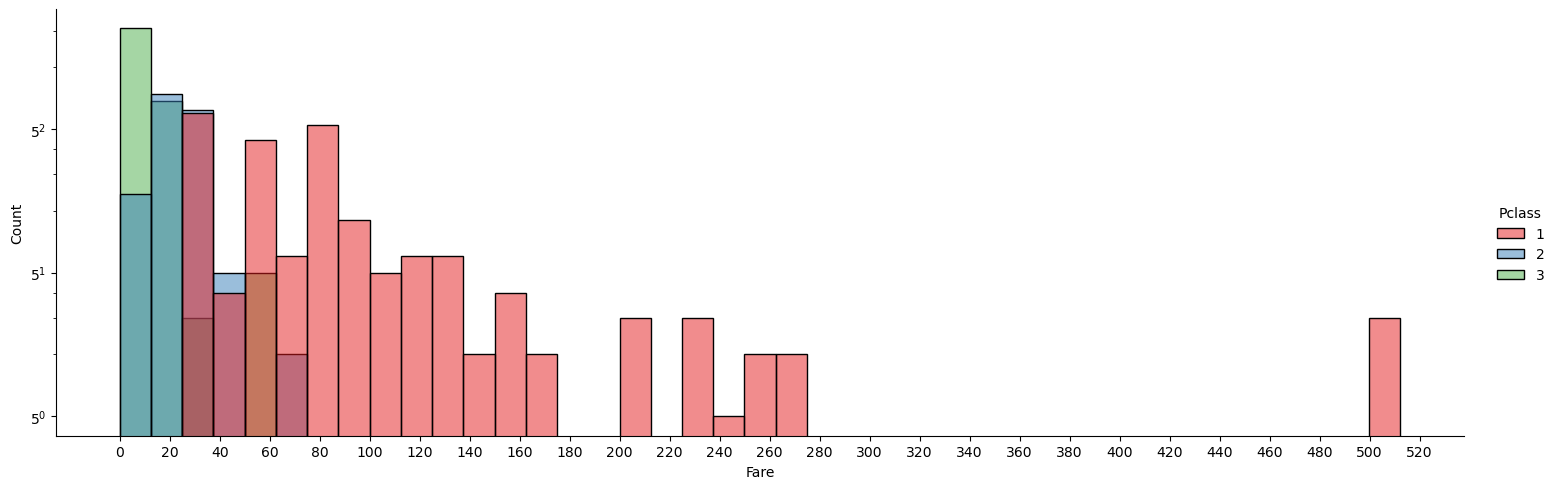

In [18]:
sns.displot(data=dfv01,  x='Fare', hue='Pclass',kind='hist', aspect=3, log_scale=(0,5),palette=sns.color_palette("pastel",3)).set_titles("all")
Survived_Fare=dfv01["Fare"][dfv01["Survived"] == 1]
sns.displot(data=dfv01,  x=Survived_Fare, hue='Pclass',kind='hist', aspect=3, log_scale=(0,5),palette=sns.color_palette("Set1",3 )).set_titles("survived")
plt.xticks([x for x in range(0,540,20)])
plt.show()

    Insights from the graph
* Distribution of numeric data is non gaussian therefore nonparametric models will better suit this classification task. 
* There are huge outliers in fare attribute
* Pclass don't have strict dependence on fare.

#### Investigating the trends in data

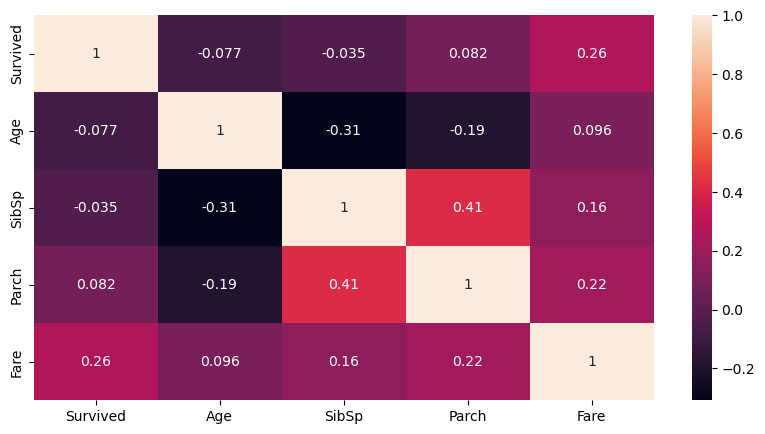

In [19]:
fig, ax = plt.subplots(figsize=(10,5)) 
dataplot = sns.heatmap(dfv01.corr(), ax=ax,annot=True)
plt.show()

    Insights from the graph
* Survived and Pclass have high negative correlation: class 1 and class 2 should have higher survival rate then class 3
* Age and Fare are moderately correlated to survival
* While Plass don't have strict dependence on fare, Fare and Pclass is highly correlated
* Pclass have high negative correlationcorrelation with age

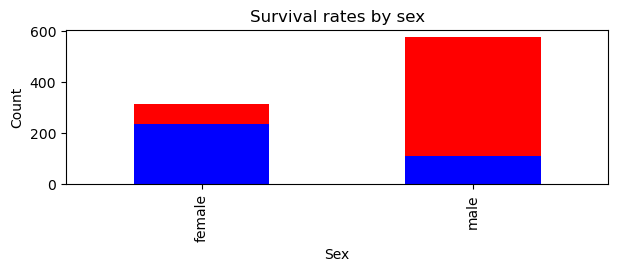

In [20]:
fig, ax = plt.subplots(figsize=(7, 2))
Survived_Sex=dfv01["Sex"][dfv01["Survived"] == 1]
pclass_fare = dfv01.groupby(["Sex"]).count()["Fare"]
pclass_fare1 = dfv01.groupby([Survived_Sex]).count()["Fare"]
pclass_fare.plot.bar(ax=ax, color='red',label='dead')
pclass_fare1.plot.bar(ax=ax, color='blue',label='survived')
_ = ax.set(
    title="Survival rates by sex",
    xlabel="Sex",
    ylabel="Count",
)

* Females had higher survival rates then males

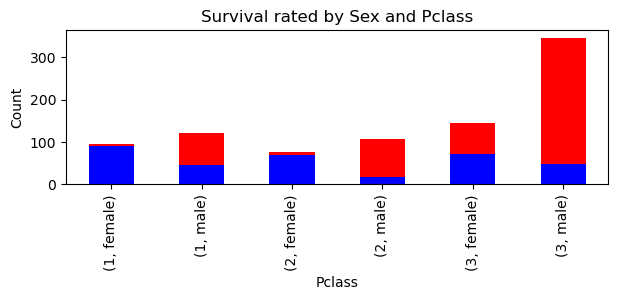

In [21]:
fig, ax = plt.subplots(figsize=(7, 2))
Survived_Sex=dfv01["Sex"][dfv01["Survived"] == 1]
pclass_fare = dfv01.groupby(["Pclass","Sex"]).count()["Fare"]
pclass_fare1 = dfv01.groupby(["Pclass",Survived_Sex]).count()["Fare"]
pclass_fare.plot.bar(ax=ax, color='red',label='dead')
pclass_fare1.plot.bar(ax=ax, color='blue',label='survived')
_ = ax.set(
    title="Survival rated by Sex and Pclass",
    xlabel="Pclass",
    ylabel="Count",
)

    Insights from the graph
* Seems like women given priorty for rescue regardless of Pclass

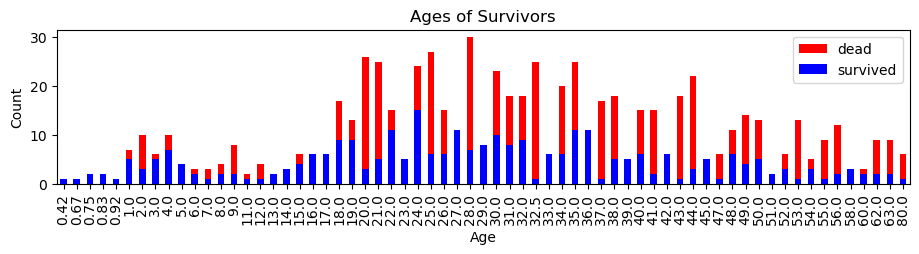

In [22]:
fig, ax = plt.subplots(figsize=(11, 2))
Survived_Age=dfv01["Age"][dfv01["Survived"] == 1]
pclass_fare2 = dfv01.groupby("Age").count()["Survived"]
pclass_fare2.plot.bar(ax=ax, color='Red',label='dead')
pclass_fare = dfv01.groupby(Survived_Age).count()["Survived"]
pclass_fare.plot.bar(ax=ax, color='Blue', label='survived')
_ = ax.set(
    title="Ages of Survivors",
    xlabel="Age",
    ylabel="Count",
)
plt.legend()
plt.show()

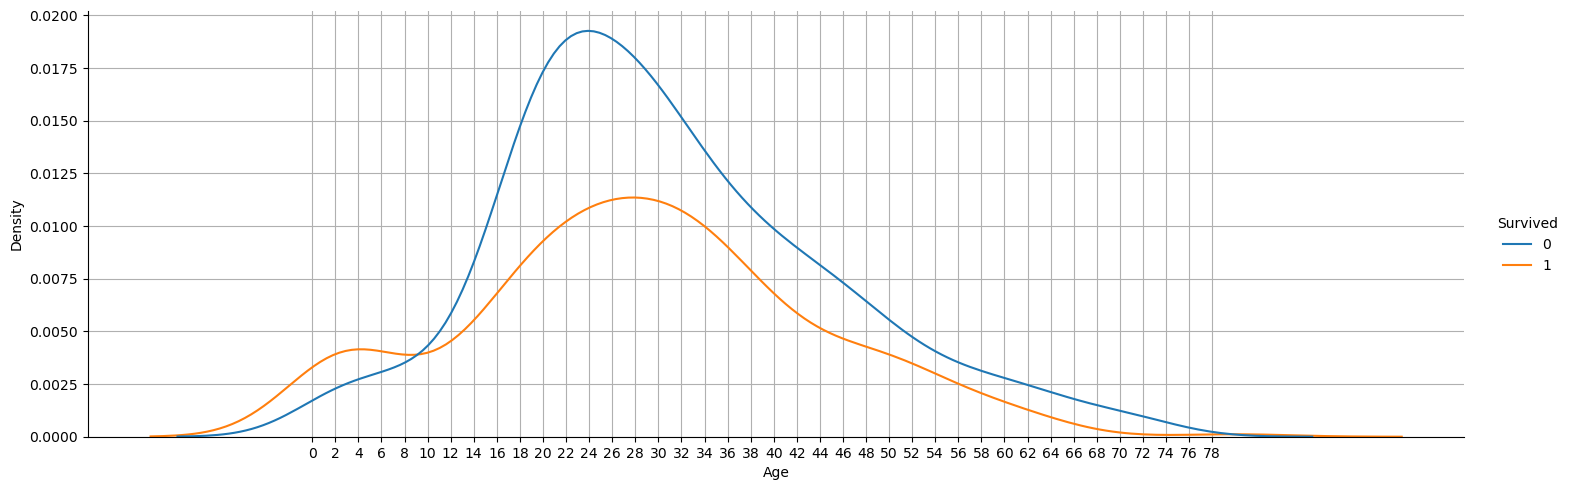

In [23]:
ax=sns.displot( dfv01 , x = 'Age', hue='Survived' , kind = 'kde',aspect=3)
ax.set(xticks=[x for x in range(int(dfv01['Age'].min()),int(dfv01['Age'].max()),2)])
plt.grid() 
plt.show()

    Insights from the graphs
* seem like children with age up until 9 given priority for rescue,survival rates  are higher then death rates
* other ages seems similar rates of survial

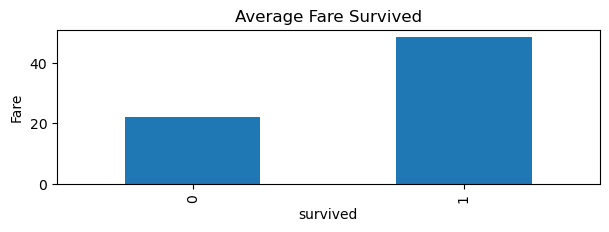

In [24]:
fig, ax = plt.subplots(figsize=(7, 2))
pclass_fare = dfv01.groupby(["Survived"]).mean()["Fare"]
pclass_fare.plot.bar(ax=ax)
_ = ax.set(
    title="Average Fare Survived",
    xlabel="survived",
    ylabel="Fare",
)

    Insights from the graph
* People who paid more survived more so average fare of survivors double the average fare of ppl lost

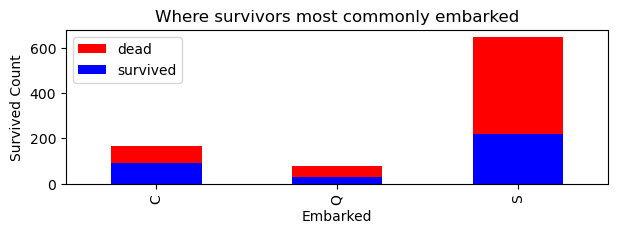

In [25]:
fig, ax = plt.subplots(figsize=(7, 2))
Survived_Embark=dfv01["Embarked"][dfv01["Survived"] == 1]
pclass_fare = dfv01.groupby(Survived_Embark).count()["Survived"]
pclass_fare2 = dfv01.groupby("Embarked").count()["Survived"]
pclass_fare2.plot.bar(ax=ax, color='red',label='dead')
pclass_fare.plot.bar(ax=ax, color='blue',label='survived')
_ = ax.set(
    title="Where survivors most commonly embarked",
    xlabel="Embarked",
    ylabel="Survived Count",
)
plt.legend()
plt.show()

    Insights from the graph
* Embarked is less correlated with survival but less then 50% of people embark on S survied.

In [26]:
Deck=dfv01['Cabin'].str[0]
dfv01.groupby(['Pclass',Deck]).count()["PassengerId"]

Pclass  Cabin
1       A        15
        B        47
        C        59
        D        29
        E        25
        F         0
        G         0
        T         1
2       A         0
        B         0
        C         0
        D         4
        E         4
        F         8
        G         0
        T         0
3       A         0
        B         0
        C         0
        D         0
        E         3
        F         5
        G         4
        T         0
Name: PassengerId, dtype: int64

In [27]:
dfv01["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

#### Data Quality Plan
* Derive a feature called ticket frequency(idea_source:https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial)
* Fix problem with empty values/outliers in cabin, extract first letter to represent deck and fill unknown for most common deck for Pclass. (idea source: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* Derive title from name (idea source: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* Derive a new feature "alt_sex" which have female, male, female_kid(age<9), male_kid(age<9) classes. 
* Derive a feature, "caretaker" to mark adults traveling with children(age<9)
* Derive feature "groupsize"
* Derive a feature "solotraveler"
* Derive fare per person (idea source: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* Binary encode category features
* age contains missing values, steps to deal with it. 
    * use knn imputer after splits
* bin age to 10 interval labeled by bin means
* as binning fare to 11 intervals not possible as not all intervals will have values, bin fare by 11 equal sized bins 

##### Deriving new features replacing old

In [28]:
def new_features(dfv01):
    
    #deriving title from name
    title = [i.split(',')[1].split('.')[0].strip() for i in dfv01['Name']]
    dfv01['Title'] = pd.Series(title)
    dfv01['Title'] = dfv01['Title'].astype('category')
    
    #deriving ticket frequency
    dfv01['Ticket_Frequency'] = dfv01.groupby('Ticket')['Ticket'].transform('count')
    

    #fixing cabin converting to deck
    dfv01['Cabin'] = dfv01['Cabin'].fillna('Unknown')
    dfv01['Deck'] = dfv01['Cabin'].str[0]
    dfv01.drop('Cabin', axis=1, inplace=True)
    dfv01['Deck'] = np.where((dfv01['Pclass']==1) & (dfv01['Pclass']=='U'),'C',
                     np.where((dfv01['Pclass']==2) & (dfv01['Pclass']=='U'),'D',
                     np.where((dfv01['Pclass']==3) & (dfv01['Pclass']=='U'),'G',
                     np.where(dfv01['Deck']=='T','C',dfv01['Deck']))))
    dfv01['Deck'] = dfv01['Deck'].astype('category')

    #derive a new feature to clasify male female or children
    dfv01.loc[dfv01['Age']<9,'Sex_new']='children'
    dfv01['Sex_new']=dfv01['Sex_new'].fillna(dfv01['Sex'])
    dfv01['Sex_new'] = dfv01['Sex_new'].astype('object')
    dfv01['Sex'] = dfv01['Sex'].astype('object')
    dfv01['alt_sex']=np.where(dfv01['Sex_new']=='children',dfv01['Sex_new']+'_'+dfv01['Sex'],dfv01['Sex_new'])
    dfv01['alt_sex'] = dfv01['alt_sex'].astype('category')
    
    #Derive a feature, "caretaker" to mark adults with traveling with children(age<18)
    dfv01['Name'] = dfv01['Name'].str.split(", ", expand=True)[0].str.split(".", expand=True)[0]
    dfv01.loc[dfv01['Age']<9,'isChildren']=1
    dfv01['isChildren']=dfv01['isChildren'].fillna(0)
    idx= dfv01.groupby(['Name'])['isChildren'].transform(sum)>0
    dfv01.loc[idx,'fam_w_c']=1
    dfv01['fam_w_c']=dfv01['fam_w_c'].fillna(0)
    dfv01.loc[(dfv01['fam_w_c']+dfv01['isChildren'])==1,'caretaker']=1
    dfv01['caretaker']=dfv01['caretaker'].fillna(0)

    
    #Derive a feature "solotraveler"
    dfv01.loc[(dfv01['SibSp']+dfv01['Parch']) ==0,'solotraveler']=1
    dfv01['solotraveler']=dfv01['solotraveler'].fillna(0)
    
    #Derive a feature "groupsize"
    dfv01['groupsize'] = dfv01['SibSp'] + dfv01['Parch'] + 1
    
    #Derive a feature "Fare_Per_Person"
    dfv01['Fare_Per_Person']=dfv01['Fare']/(dfv01['groupsize'])
    #log transoforming to counter skewness
    #dfv01["Fare_Per_Person"] = dfv01["Fare_Per_Person"].map(lambda i: np.log(i) if i > 0 else 0)
    
    #Drop columns not needed for training
    dfv01.drop('SibSp', axis=1, inplace=True)
    dfv01.drop('Parch', axis=1, inplace=True)
    dfv01.drop('Sex_new', axis=1, inplace=True)
    dfv01.drop('Sex', axis=1, inplace=True)
    dfv01.drop('fam_w_c', axis=1, inplace=True)
    dfv01.drop('Name', axis=1, inplace=True)
    dfv01.drop('isChildren', axis=1, inplace=True)
    dfv01.drop('Fare', axis=1, inplace=True)
    dfv01.drop('PassengerId', axis=1, inplace=True)
    dfv01.drop('Ticket', axis=1, inplace=True)
    
    return dfv01

In [29]:
dfv01=new_features(dfv01)
dfv01.head(5)

Survived Pclass   Age Embarked Title  Ticket_Frequency Deck alt_sex  \
0         0      3  22.0        S    Mr                 1    U    male   
1         1      1  38.0        C   Mrs                 1    C  female   
2         1      3  26.0        S  Miss                 1    U  female   
3         1      1  35.0        S   Mrs                 2    C  female   
4         0      3  35.0        S    Mr                 1    U    male   

   caretaker  solotraveler  groupsize  Fare_Per_Person  
0        0.0           0.0          2          3.62500  
1        0.0           0.0          2         35.64165  
2        0.0           1.0          1          7.92500  
3        0.0           0.0          2         26.55000  
4        0.0           1.0          1          8.05000

In [30]:
dfv01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Survived          891 non-null    int64   
 1   Pclass            891 non-null    category
 2   Age               714 non-null    float64 
 3   Embarked          891 non-null    category
 4   Title             891 non-null    category
 5   Ticket_Frequency  891 non-null    int64   
 6   Deck              891 non-null    category
 7   alt_sex           891 non-null    category
 8   caretaker         891 non-null    float64 
 9   solotraveler      891 non-null    float64 
 10  groupsize         891 non-null    int64   
 11  Fare_Per_Person   891 non-null    float64 
dtypes: category(5), float64(4), int64(3)
memory usage: 54.7 KB


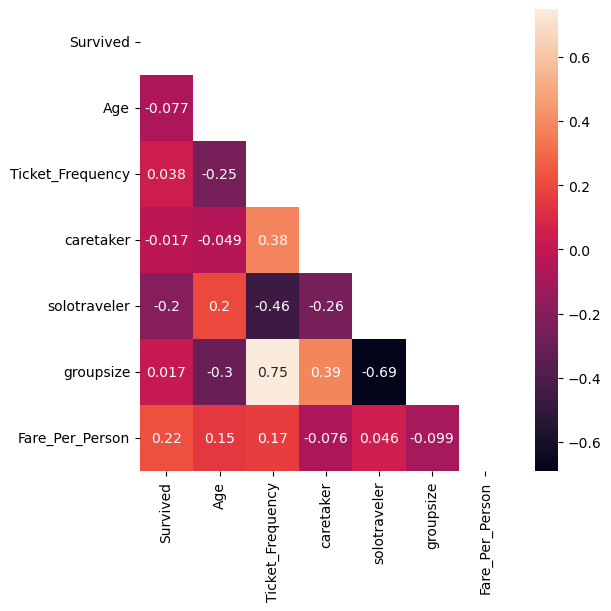

In [31]:
fig, ax = plt.subplots(figsize=(6,6)) 
mask=np.zeros_like(dfv01.corr())
mask[np.triu_indices_from(mask)]=True
dataplot = sns.heatmap(dfv01.corr(), ax=ax,annot=True, mask=mask)
plt.show()

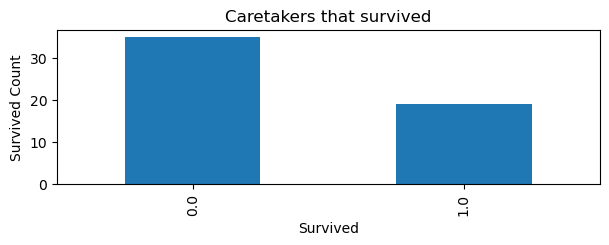

In [32]:
fig, ax = plt.subplots(figsize=(7, 2))
Survived_caretaker=dfv01["Survived"][dfv01["caretaker"] == 1]
pclass_fare = dfv01.groupby(Survived_caretaker).count()["Survived"]
pclass_fare.plot.bar(ax=ax,label='survived')
_ = ax.set(
    title="Caretakers that survived",
    xlabel="Survived",
    ylabel="Survived Count",
)
plt.show()

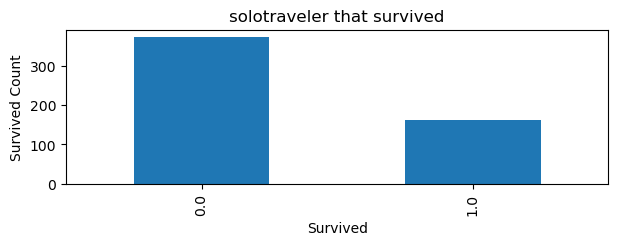

In [33]:
fig, ax = plt.subplots(figsize=(7, 2))
Survived_caretaker=dfv01["Survived"][dfv01["solotraveler"] == 1]
pclass_fare = dfv01.groupby(Survived_caretaker).count()["Survived"]
pclass_fare.plot.bar(ax=ax,label='survived')
_ = ax.set(
    title="solotraveler that survived",
    xlabel="Survived",
    ylabel="Survived Count",
)
plt.show()

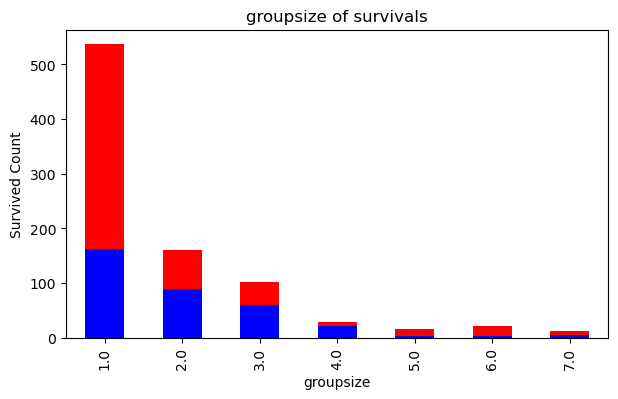

In [34]:
fig, ax = plt.subplots(figsize=(7, 4))
Survived_group=dfv01["groupsize"][dfv01["Survived"] == 1]
pclass_fare = dfv01.groupby("groupsize").count()["Survived"]
pclass_fare2 = dfv01.groupby(Survived_group).count()["Survived"]
pclass_fare.plot.bar(ax=ax, color='red',label='dead')
pclass_fare2.plot.bar(ax=ax, color='blue',label='survived')
_ = ax.set(
    title="groupsize of survivals",
    xlabel="groupsize",
    ylabel="Survived Count",
)
plt.show()

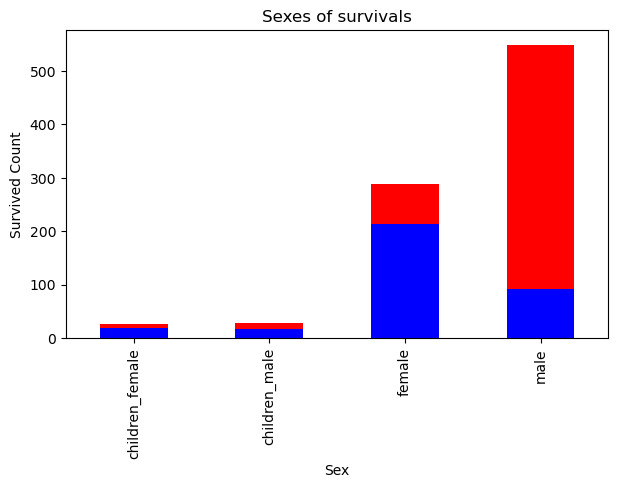

In [35]:
fig, ax = plt.subplots(figsize=(7, 4))
Survived_sex_new=dfv01["alt_sex"][dfv01["Survived"] == 1]
pclass_fare = dfv01.groupby("alt_sex").count()["Survived"]
pclass_fare2 = dfv01.groupby(Survived_sex_new).count()["Survived"]
pclass_fare.plot.bar(ax=ax, color='red',label='dead')
pclass_fare2.plot.bar(ax=ax, color='blue',label='survived')
_ = ax.set(
    title="Sexes of survivals",
    xlabel="Sex",
    ylabel="Survived Count",
)
plt.show()

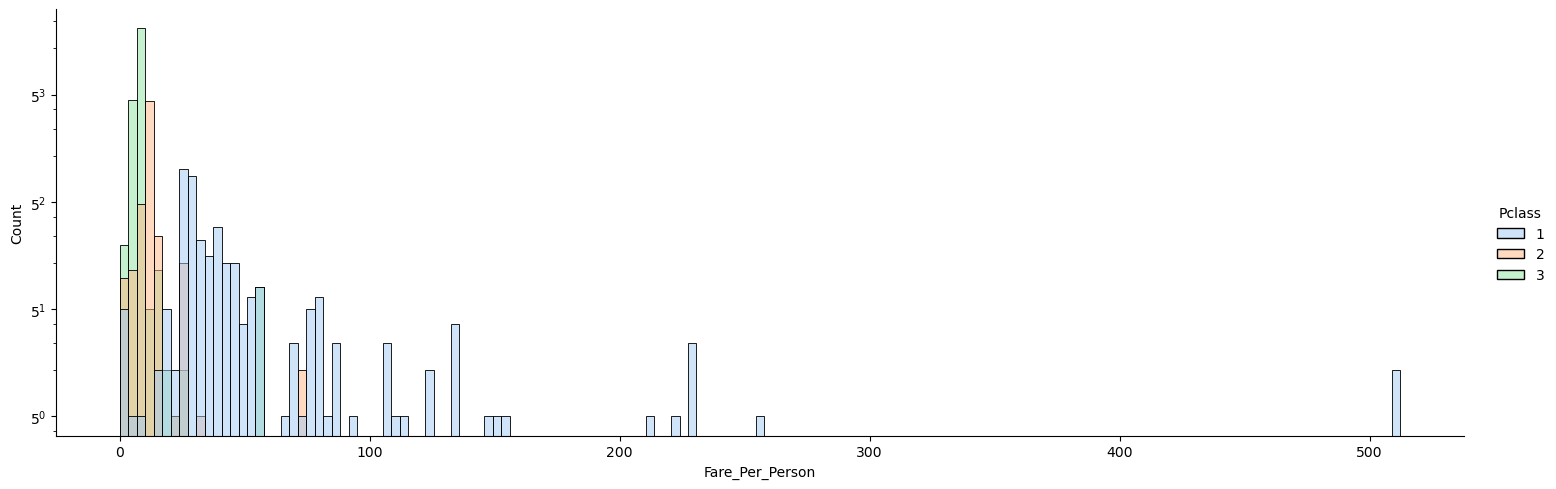

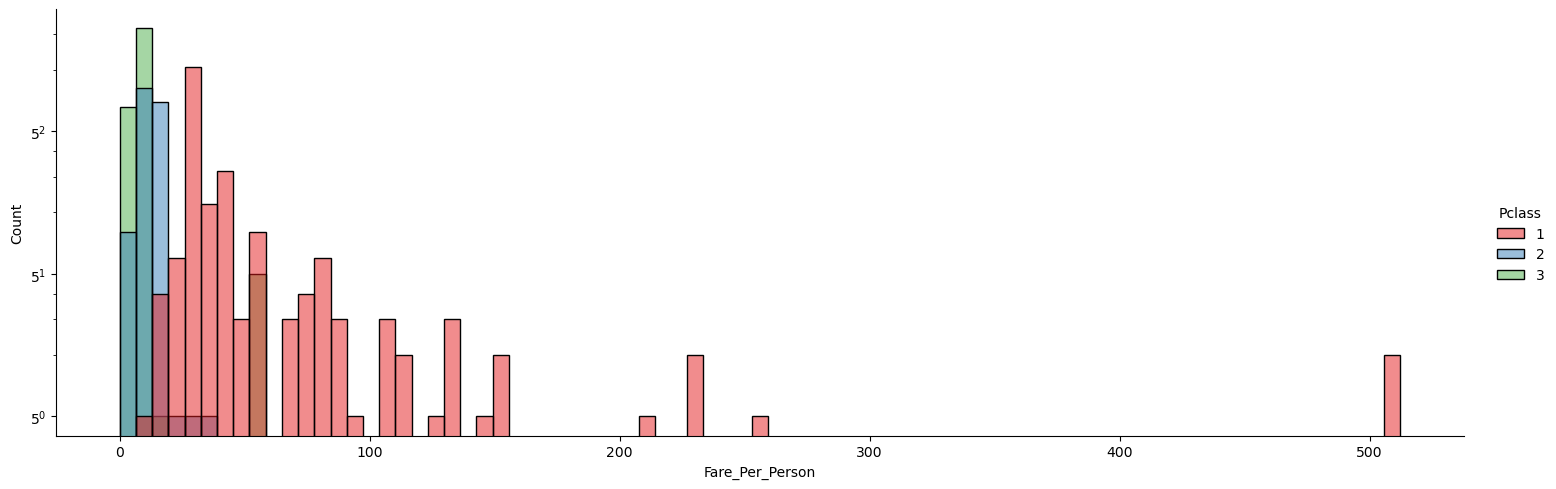

In [36]:
sns.displot(data=dfv01,  x='Fare_Per_Person', hue='Pclass',kind='hist', aspect=3, log_scale=(0,5),palette=sns.color_palette("pastel",3)).set_titles("all")
Survived_Fare=dfv01["Fare_Per_Person"][dfv01["Survived"] == 1]
sns.displot(data=dfv01,  x=Survived_Fare, hue='Pclass',kind='hist', aspect=3, log_scale=(0,5),palette=sns.color_palette("Set1",3 )).set_titles("survived")
plt.show()

#### Creating feature and target dataframes

In [37]:
dfv01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Survived          891 non-null    int64   
 1   Pclass            891 non-null    category
 2   Age               714 non-null    float64 
 3   Embarked          891 non-null    category
 4   Title             891 non-null    category
 5   Ticket_Frequency  891 non-null    int64   
 6   Deck              891 non-null    category
 7   alt_sex           891 non-null    category
 8   caretaker         891 non-null    float64 
 9   solotraveler      891 non-null    float64 
 10  groupsize         891 non-null    int64   
 11  Fare_Per_Person   891 non-null    float64 
dtypes: category(5), float64(4), int64(3)
memory usage: 54.7 KB


In [38]:
features=['Pclass','Age','Embarked','Deck','alt_sex','solotraveler','caretaker','groupsize','Fare_Per_Person','Title','Ticket_Frequency']
y = dfv01[["Survived"]]
X = dfv01[features]
category_columns_X = X.select_dtypes(['category']).columns

#### encoding category columns

In [39]:
#ordinal encoding because will be using tree based models so better to keep dimensionality low. 
class ordinal:
    "takes dataframe and list of features to be encoded and onehot encode"
    def __init__(self,X, category_columns_X):
        self.X=X
        self.category_columns_X=category_columns_X
        self.oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        self.oe_category_  = self.oe.fit(self.X[self.category_columns_X])
    def encode(self,X):
        columns=self.oe_category_.get_feature_names_out(X[self.category_columns_X].columns)
        columns=[x+'_code' for x in columns]
        print(columns)
        oe_category_data=self.oe_category_.transform(X[self.category_columns_X])
        X=X.join(pd.DataFrame(oe_category_data, columns=columns))
        X.drop(self.category_columns_X, axis=1, inplace=True)
        return X

In [40]:
encoder=ordinal(X,category_columns_X)
X=encoder.encode(X)
X.head(2)

['Pclass_code', 'Embarked_code', 'Deck_code', 'alt_sex_code', 'Title_code']


Age  solotraveler  caretaker  groupsize  Fare_Per_Person  \
0  22.0           0.0        0.0          2          3.62500   
1  38.0           0.0        0.0          2         35.64165   

   Ticket_Frequency  Pclass_code  Embarked_code  Deck_code  alt_sex_code  \
0                 1          2.0            2.0        7.0           3.0   
1                 1          0.0            0.0        2.0           2.0   

   Title_code  
0        11.0  
1        12.0

#### Performing splits

In [41]:
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                  y,
                                                  test_size=0.3,
                                                  random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,
                                                    y_rem,
                                                    test_size=0.5,
                                                    random_state=1)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
None

(623, 11) (623, 1)
(134, 11) (134, 1)
(134, 11) (134, 1)


#### Imputing null values

In [42]:
def imputer(X_train):
    #to deal with nan values in age, use knn imputer based on "title","solotraveler","caretaker","alt_sex"
    imputer_age=KNNImputer(n_neighbors=1, add_indicator=False)
    # to deal with any other nans in train or test.
    imputer = KNNImputer(n_neighbors=3, add_indicator=False)
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    
    #first imputing age specifically
    find_age_features=["Age","Title_code","solotraveler","caretaker","alt_sex_code"]
    df_age=X_train_scaled[find_age_features]
    df_age=pd.DataFrame(imputer_age.fit_transform(df_age), columns=df_age.columns)
    X_train_scaled['Age'] = df_age['Age'] 
    
    
    imputer.fit(X_train_scaled)
    X_train_Imputed=pd.DataFrame(imputer.transform(X_train_scaled), columns=X_train_scaled.columns)
    X_train_Imputed=pd.DataFrame(scaler.inverse_transform(X_train_Imputed), columns=X_train_Imputed.columns)
    return X_train_Imputed

In [43]:
X_train_Imputed=imputer(X_train)
display(X_train_Imputed.info())
X_valid_Imputed=imputer(X_valid)
display(X_valid_Imputed.info())
X_test_Imputed=imputer(X_test)
display(X_test_Imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               623 non-null    float64
 1   solotraveler      623 non-null    float64
 2   caretaker         623 non-null    float64
 3   groupsize         623 non-null    float64
 4   Fare_Per_Person   623 non-null    float64
 5   Ticket_Frequency  623 non-null    float64
 6   Pclass_code       623 non-null    float64
 7   Embarked_code     623 non-null    float64
 8   Deck_code         623 non-null    float64
 9   alt_sex_code      623 non-null    float64
 10  Title_code        623 non-null    float64
dtypes: float64(11)
memory usage: 53.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               134 non-null    float64
 1   solotraveler      134 non-null    float64
 2   caretaker         134 non-null    float64
 3   groupsize         134 non-null    float64
 4   Fare_Per_Person   134 non-null    float64
 5   Ticket_Frequency  134 non-null    float64
 6   Pclass_code       134 non-null    float64
 7   Embarked_code     134 non-null    float64
 8   Deck_code         134 non-null    float64
 9   alt_sex_code      134 non-null    float64
 10  Title_code        134 non-null    float64
dtypes: float64(11)
memory usage: 11.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               134 non-null    float64
 1   solotraveler      134 non-null    float64
 2   caretaker         134 non-null    float64
 3   groupsize         134 non-null    float64
 4   Fare_Per_Person   134 non-null    float64
 5   Ticket_Frequency  134 non-null    float64
 6   Pclass_code       134 non-null    float64
 7   Embarked_code     134 non-null    float64
 8   Deck_code         134 non-null    float64
 9   alt_sex_code      134 non-null    float64
 10  Title_code        134 non-null    float64
dtypes: float64(11)
memory usage: 11.6 KB


None

In [44]:
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
class binning:
    def __init__(self,X_train_Imputed, feature, bins):
        self.X_train_Imputed=X_train_Imputed
        self.feature=feature
        self.bins=bins
        self.bin_means, self.bin_edges, self.binnumber = stats.binned_statistic(self.X_train_Imputed[self.feature], self.X_train_Imputed[self.feature], statistic='mean', bins=self.bins)
        self.bin_edges = np.concatenate(([-np.inf], self.bin_edges[1:-1], [np.inf]))
        self.bin_intervals = pd.IntervalIndex.from_arrays(self.bin_edges[:-1], self.bin_edges[1:],closed='both')
        
        self.kbin = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
        self.kbin_category_  = self.kbin.fit(self.X_train_Imputed[[self.feature]])
        self.bin_edges_=self.kbin_category_.bin_edges_
        
    def bin(self, X_train_Imputed):
        def set_mean(x,bin_intervals, bin_means):
            interval_index=0
            for interval in bin_intervals:
                if x in interval:
                    return round(bin_means[interval_index],0)
                else:
                    interval_index+=1
        binned_feature='binned_'+self.feature
        X_train_Imputed[binned_feature] = X_train_Imputed[self.feature].apply(lambda x: set_mean(x,self.bin_intervals, self.bin_means))
        X_train_Imputed.drop(self.feature, axis=1, inplace=True)
        return X_train_Imputed
    
    def bin_quantile(self, X_train_Imputed):
        kbin_category_data=self.kbin_category_.transform(X_train_Imputed[[self.feature]])
        binned_column='binned_'+self.feature
        X_train_Imputed=X_train_Imputed.join(pd.DataFrame(kbin_category_data, columns=[binned_column]))
        X_train_Imputed.drop(self.feature, axis=1, inplace=True)
        return X_train_Imputed

In [45]:
bin_maker=binning(X_train_Imputed, 'Age', 10)
display(bin_maker.bin_intervals)
X_train_Imputed=bin_maker.bin(X_train_Imputed)
display(X_train_Imputed.info())
X_test_Imputed=bin_maker.bin(X_test_Imputed)
display(X_test_Imputed.info())
X_valid_Imputed=bin_maker.bin(X_valid_Imputed)
display(X_valid_Imputed.info())

IntervalIndex([[-inf, 8.603], [8.603, 16.536], [16.536, 24.469], [24.469, 32.402], [32.402, 40.335], [40.335, 48.268], [48.268, 56.201], [56.201, 64.134], [64.134, 72.067], [72.067, inf]], dtype='interval[float64, both]')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   solotraveler      623 non-null    float64
 1   caretaker         623 non-null    float64
 2   groupsize         623 non-null    float64
 3   Fare_Per_Person   623 non-null    float64
 4   Ticket_Frequency  623 non-null    float64
 5   Pclass_code       623 non-null    float64
 6   Embarked_code     623 non-null    float64
 7   Deck_code         623 non-null    float64
 8   alt_sex_code      623 non-null    float64
 9   Title_code        623 non-null    float64
 10  binned_Age        623 non-null    float64
dtypes: float64(11)
memory usage: 53.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   solotraveler      134 non-null    float64
 1   caretaker         134 non-null    float64
 2   groupsize         134 non-null    float64
 3   Fare_Per_Person   134 non-null    float64
 4   Ticket_Frequency  134 non-null    float64
 5   Pclass_code       134 non-null    float64
 6   Embarked_code     134 non-null    float64
 7   Deck_code         134 non-null    float64
 8   alt_sex_code      134 non-null    float64
 9   Title_code        134 non-null    float64
 10  binned_Age        134 non-null    float64
dtypes: float64(11)
memory usage: 11.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   solotraveler      134 non-null    float64
 1   caretaker         134 non-null    float64
 2   groupsize         134 non-null    float64
 3   Fare_Per_Person   134 non-null    float64
 4   Ticket_Frequency  134 non-null    float64
 5   Pclass_code       134 non-null    float64
 6   Embarked_code     134 non-null    float64
 7   Deck_code         134 non-null    float64
 8   alt_sex_code      134 non-null    float64
 9   Title_code        134 non-null    float64
 10  binned_Age        134 non-null    float64
dtypes: float64(11)
memory usage: 11.6 KB


None

In [46]:
bin_maker_fare=binning(X_train_Imputed, 'Fare_Per_Person', 11)
display(bin_maker_fare.bin_edges_)
X_train_Imputed=bin_maker_fare.bin_quantile(X_train_Imputed)
display(X_train_Imputed.info())
X_test_Imputed=bin_maker_fare.bin_quantile(X_test_Imputed)
display(X_test_Imputed.info())
X_valid_Imputed=bin_maker_fare.bin_quantile(X_valid_Imputed)
display(X_valid_Imputed.info())

array([array([  0.        ,   7.22446207,  18.81995967,  36.46963166,
               59.67340283,  81.13575625,  98.10054667, 119.98422167,
              142.47464167, 189.775525  , 241.126575  , 256.1646    ])],
      dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   solotraveler            623 non-null    float64
 1   caretaker               623 non-null    float64
 2   groupsize               623 non-null    float64
 3   Ticket_Frequency        623 non-null    float64
 4   Pclass_code             623 non-null    float64
 5   Embarked_code           623 non-null    float64
 6   Deck_code               623 non-null    float64
 7   alt_sex_code            623 non-null    float64
 8   Title_code              623 non-null    float64
 9   binned_Age              623 non-null    float64
 10  binned_Fare_Per_Person  623 non-null    float64
dtypes: float64(11)
memory usage: 53.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   solotraveler            134 non-null    float64
 1   caretaker               134 non-null    float64
 2   groupsize               134 non-null    float64
 3   Ticket_Frequency        134 non-null    float64
 4   Pclass_code             134 non-null    float64
 5   Embarked_code           134 non-null    float64
 6   Deck_code               134 non-null    float64
 7   alt_sex_code            134 non-null    float64
 8   Title_code              134 non-null    float64
 9   binned_Age              134 non-null    float64
 10  binned_Fare_Per_Person  134 non-null    float64
dtypes: float64(11)
memory usage: 11.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   solotraveler            134 non-null    float64
 1   caretaker               134 non-null    float64
 2   groupsize               134 non-null    float64
 3   Ticket_Frequency        134 non-null    float64
 4   Pclass_code             134 non-null    float64
 5   Embarked_code           134 non-null    float64
 6   Deck_code               134 non-null    float64
 7   alt_sex_code            134 non-null    float64
 8   Title_code              134 non-null    float64
 9   binned_Age              134 non-null    float64
 10  binned_Fare_Per_Person  134 non-null    float64
dtypes: float64(11)
memory usage: 11.6 KB


None

In [47]:
display(X_train_Imputed.isnull().values.any())
display(X_test_Imputed.isnull().values.any())
display(X_valid_Imputed.isnull().values.any())

False

False

False

#### Checking-out correlations making a prediction

In [48]:
cv_folds=StratifiedKFold(n_splits=10)

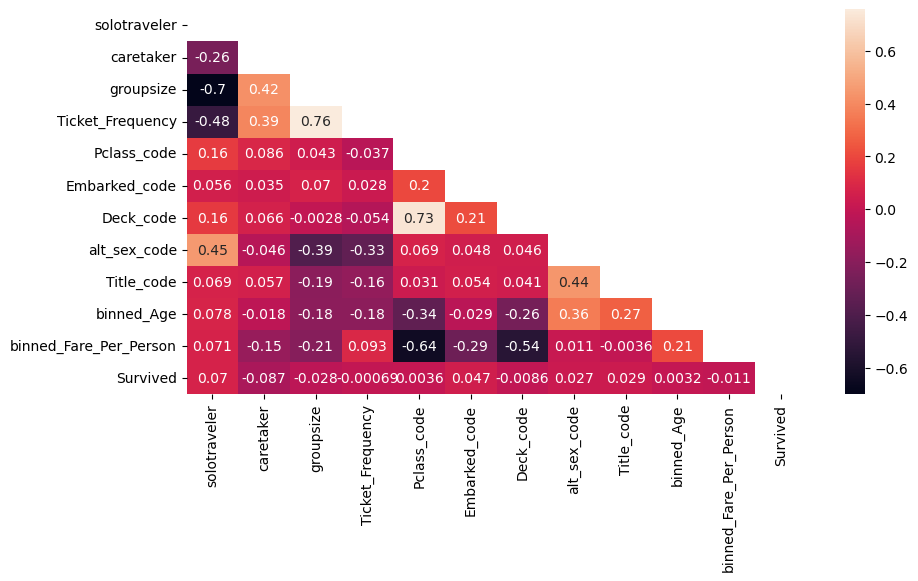

In [49]:
fig, ax = plt.subplots(figsize=(10,5) )
cormat=pd.concat([X_train_Imputed,y_train],axis=1).corr()
mask=np.zeros_like(cormat)
mask[np.triu_indices_from(mask)]=True
dataplot = sns.heatmap(cormat, mask=mask, ax=ax,annot=True)
plt.show()

In [50]:
selected_features=X_train_Imputed.columns
X_train_efs = X_train_Imputed[selected_features]
X_valid_efs = X_valid_Imputed[selected_features]
X_test_efs = X_test_Imputed[selected_features]

In [51]:
scaler=StandardScaler()
Xt_train = pd.DataFrame(scaler.fit_transform(X_train_efs), columns = X_train_efs.columns)
Xt_valid= pd.DataFrame(scaler.fit_transform(X_valid_efs), columns = X_valid_efs.columns)
Xt_test = pd.DataFrame(scaler.fit_transform(X_test_efs), columns = X_test_efs.columns)

In [52]:
import sklearn.model_selection
model = DecisionTreeClassifier(random_state=0)
cv_results = sklearn.model_selection.cross_validate(model, Xt_train, y_train.values.ravel(), cv=cv_folds,scoring='balanced_accuracy')
print(cv_results)
print(f"Mean test score {cv_results['test_score'].mean()}")

{'fit_time': array([0.0015955 , 0.00126123, 0.00122476, 0.00121665, 0.00118589,
       0.00106573, 0.0011344 , 0.00107813, 0.00109911, 0.00104952]), 'score_time': array([0.00088787, 0.00073361, 0.00065589, 0.00066614, 0.00064898,
       0.00065398, 0.00063753, 0.00064325, 0.00062418, 0.00062513]), 'test_score': array([0.85380435, 0.72934783, 0.84456522, 0.82613636, 0.73295455,
       0.71022727, 0.81828317, 0.81326644, 0.82218506, 0.81438127])}
Mean test score 0.7965151515151516


## Testing different ensemble models

Selecting one bagging (RFC) and 2 boosting classifiers ( XGBoost, CatBoost) because boosting classifiers tends to overfit outliers more then bagging classifiers so need to balance it out to minimise generalisation error. Also there is class imbalance such that survivors less then non-survirors therefore using balanced accuracy for scoring.

In [53]:
#İnitializing dictionaries to store model performance parameters for comparison
model_valid_accuracy_comparisons = dict()

### RFC

In [54]:
clf = RandomForestClassifier()
clf.fit(Xt_train, y_train.values.ravel())

RandomForestClassifier()

In [55]:
y_valid_rfr=clf.predict(Xt_valid)
accuracy_score(y_valid, y_valid_rfr)

0.7388059701492538

In [56]:
# Set up the parameter grid to search for additional params
param_grid_RFC = {'n_estimators':  [10, 50, 100, 300,500],\
            'criterion': ['gini'],\
            'max_features': ['log2'],\
            'max_depth': [2, 4, 6, 8, 10], \
            'min_samples_split': [5,10,.03,.05,.10],\
            'min_samples_leaf':[5,10],\
            'bootstrap':[False],\
            'random_state':[0]
            }
# Perform the search
my_tuned_rfc = sklearn.model_selection.GridSearchCV(RandomForestClassifier(),\
                                                    param_grid=param_grid_RFC, cv=cv_folds, verbose = 3, n_jobs = -1, scoring='balanced_accuracy')
my_tuned_rfc.fit(Xt_train, y_train.values.ravel())


Fitting 10 folds for each of 250 candidates, totalling 2500 fits
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.853 total time=   0.0s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.729 total time=   0.3s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.785 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.884 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.844 total time=   0.0s
[CV 4/

[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.751 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.745 total time=   0.3s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.844 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.826 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.826 total time=   0.3s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_feat

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.844 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.756 total time=   0.7s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.785 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.853 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.884 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.866 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.756 total time=   0.3s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.756 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.756 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_featur

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.813 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.866 total time=   0.6s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.826 total time=   0.6s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.826 total time=   0.6s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.826 total time=   0.5s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_

[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.824 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.841 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.826 total time=   0.3s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.824 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.800 total time=   0.0s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_feature

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.813 total time=   0.4s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.822 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.857 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.857 total time=   0.4s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.857 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4

[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.764 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.836 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.857 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.861 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.861 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4,

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.853 total time=   0.2s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.776 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.836 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.814 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.847 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4,

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.801 total time=   0.4s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.866 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.836 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.845 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.801 total time=   0.3s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, m

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.866 total time=   0.0s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.823 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.773 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.773 total time=   0.4s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.782 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_de

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.756 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.841 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.849 total time=   0.5s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.849 total time=   0.5s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.849 total time=   0.5s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.782 total time=   0.0s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.779 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.822 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.751 total time=   0.5s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.779 total time=   0.5s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_featur

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.813 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.836 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.814 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.814 total time=   0.5s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.782 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.785 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.785 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.785 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.785 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, 

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.828 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.836 total time=   0.4s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.798 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.789 total time=   0.0s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.704 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_fea

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.884 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.779 total time=   0.5s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.751 total time=   0.5s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.751 total time=   0.5s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.751 total time=   0.5s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.822 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.836 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.828 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.801 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.859 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.857 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.784 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.771 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.847 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.780 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=8, 

[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.801 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.785 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.785 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.795 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.773 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_fea

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.813 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.813 total time=   0.4s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.811 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.814 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.764 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, m

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['log2'], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10, 0.03, 0.05, 0.1],
                         'n_estimators': [10, 50, 100, 300, 500],
                         'random_state': [0]},
             scoring='balanced_accuracy', verbose=3)

In [57]:
# Print details
print("Best parameters set found on development set:")
print(my_tuned_rfc.best_params_)
print(my_tuned_rfc.best_score_)

Best parameters set found on development set:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 0.1, 'n_estimators': 10, 'random_state': 0}
0.8285409698996654


Accuracy: 0.753731343283582
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        81
           1       0.73      0.60      0.66        53

    accuracy                           0.75       134
   macro avg       0.75      0.73      0.73       134
weighted avg       0.75      0.75      0.75       134

Confusion Matrix


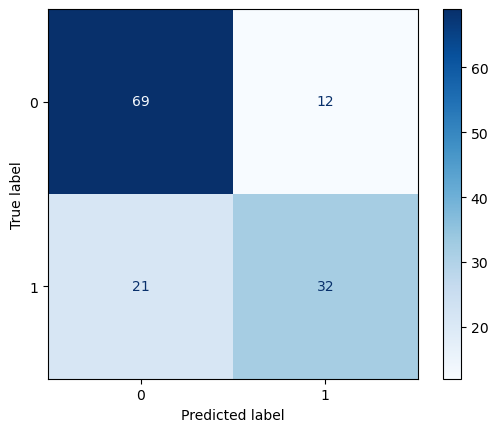

In [58]:
# Make a set of predictions for the validation data
y_pred_rfc = my_tuned_rfc.predict(Xt_valid)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred_rfc) 
model_valid_accuracy_comparisons["tuned_rfc"] = accuracy
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_valid, y_pred_rfc))

# Print confusion matrix
print("Confusion Matrix")
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_rfc, cmap = 'Blues')

### XGBoost

In [59]:
my_xgboost = XGBClassifier()
my_xgboost.fit(Xt_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [60]:
y_valid_xgboost=my_xgboost.predict(Xt_valid)
accuracy_score(y_valid, y_valid_xgboost)

0.746268656716418

In [61]:
# Set up the parameter grid to seaerch
param_grid_XG = [
 {
    'learning_rate': [.01,.03,.05,.1,.25],\
    'n_estimators': [10, 50, 100, 300],\
    'max_depth': [1,2, 4, 6, 8, 10], \
    'objective':['binary:logistic','reg:absoluteerror',], \
    'random_state':[0]}
]

# Perform the search
my_tuned_xgboost = sklearn.model_selection.GridSearchCV(XGBClassifier(),\
                                                      param_grid=param_grid_XG, cv=cv_folds, verbose = 3, n_jobs = -1,scoring='balanced_accuracy')
my_tuned_xgboost.fit(Xt_train, y_train.values.ravel())

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.776 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.813 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.857 total time=   0.4s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.822 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.801 total time=   0.1s

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=0;, score=0.853 total time=   0.6s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.853 total time=   0.6s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.853 total time=   0.6s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.853 total time=   0.6s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.844 total time=   0.6s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.785 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.784 total time=   0.4s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.758 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.771 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.835 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=8

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.844 total time=   0.4s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.844 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.828 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.844 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.844 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, ma

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.793 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.828 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.792 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.792 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.751 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_de

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.853 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.853 total time=   0.4s
[CV 9/10] END learning_rate=0.01, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.1s
[CV 7/10] END learning_rate=0.01, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END learning_rate=0.01, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.813 total time=   0.1s
[CV 5/10] END learning_rate=0.01, max_depth=2, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.884 total time=   0.0s
[CV 6/10] END learning_rate=0.01, max_depth=2, n_estimators=1

[CV 7/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.726 total time=   0.1s
[CV 8/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.783 total time=   0.1s
[CV 9/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.763 total time=   0.1s
[CV 1/10] END learning_rate=0.01, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.742 total time=   0.1s
[CV 2/10] END learning_rate=0.01, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.1s
[CV 3/10] END learning_rate=0.01, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.845 total time=   0.1s
[CV 4/10] E

[CV 8/10] END learning_rate=0.01, max_depth=2, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.813 total time=   0.0s
[CV 1/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.782 total time=   0.1s
[CV 2/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.1s
[CV 3/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.845 total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.859 total time=   0.1s
[CV 9/10] END learning_rate=0.01, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10] END learning_rate=0.01, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.0s
[CV 1/10] END learning

[CV 10/10] END learning_rate=0.05, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.772 total time=   0.1s[CV 1/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.782 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.782 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.751 total time=   0.4s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.751 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.857 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.785 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=0;, score=0.785 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.773 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.798 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth

[CV 4/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.811 total time=   0.1s
[CV 5/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.847 total time=   0.1s
[CV 6/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.857 total time=   0.1s
[CV 7/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.788 total time=   0.1s
[CV 9/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.831 total time=   0.1s
[CV 10/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.772 total time=   0.1s
[CV 3

[CV 5/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.773 total time=   0.0s
[CV 6/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 7/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.726 total time=   0.0s
[CV 8/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.761 total time=   0.0s
[CV 7/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 8/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 10/10] END learni

[CV 2/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.1s
[CV 3/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.845 total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.1s
[CV 5/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.1s
[CV 6/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.1s
[CV 7/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.1s
[CV 8/10] END learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.1s
[CV 9/10] END

[CV 2/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.1s
[CV 3/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.845 total time=   0.1s
[CV 4/10] END learning_rate=0.03, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.836 total time=   0.1s
[CV 9/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.818 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.763 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 2/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 3/10] END learn

[CV 4/10] END learning_rate=0.05, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.791 total time=   0.1s
[CV 5/10] END learning_rate=0.05, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.1s
[CV 6/10] END learning_rate=0.05, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.1s
[CV 7/10] END learning_rate=0.05, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.1s
[CV 8/10] END learning_rate=0.05, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.848 total time=   0.1s
[CV 1/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.766 total time=   0.0s
[CV 2/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.785 total time=   0.0s
[CV 3/10] END learning_r

[CV 4/10] END learning_rate=0.05, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 5/10] END learning_rate=0.05, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 6/10] END learning_rate=0.05, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 7/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.840 total time=   0.1s
[CV 8/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.813 total time=   0.1s
[CV 9/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.766 total time=   0.1s
[CV 10/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.780 total time=   0.1s
[

[CV 7/10] END learning_rate=0.03, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.866 total time=   0.3s
[CV 8/10] END learning_rate=0.03, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.813 total time=   0.3s
[CV 9/10] END learning_rate=0.03, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.784 total time=   0.3s
[CV 10/10] END learning_rate=0.03, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.771 total time=   0.3s
[CV 7/10] END learning_rate=0.1, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.726 total time=   0.0s
[CV 8/10] END learning_rate=0.1, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.761 total time=   0.0s
[CV 9/10] END learning_rate=0.1, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.726 total time=   0.0s
[CV 10/10] 

[CV 5/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 6/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.807 total time=   0.1s
[CV 2/10] END learning_rate=0.03, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.751 total time=   0.1s
[CV 3/10] END learning_rate=0.03, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.845 total time=   0.1s
[CV 4/10] END learning_rate=0.03, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.803 total time=   0.1s
[CV 5/10] END learning_rate=0.03, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.851 total time=   0.1s
[CV 6/10] E

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.25],
                          'max_depth': [1, 2, 4, 6, 8, 10],
                          'n_estimators': [10, 50, 100, 300],
                          'objective': ['binary:logistic', 'reg:absoluteerror'],
                          'random_state': [0]}],
             scoring='balanced_accuracy', verbose=3)

In [62]:
# Print details
print("Best parameters set found on development set:")
print(my_tuned_xgboost.best_params_)
print(my_tuned_xgboost.best_score_)

Best parameters set found on development set:
{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 0}
0.8288991081382384


Accuracy: 0.753731343283582
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        81
           1       0.74      0.58      0.65        53

    accuracy                           0.75       134
   macro avg       0.75      0.72      0.73       134
weighted avg       0.75      0.75      0.75       134

Confusion Matrix


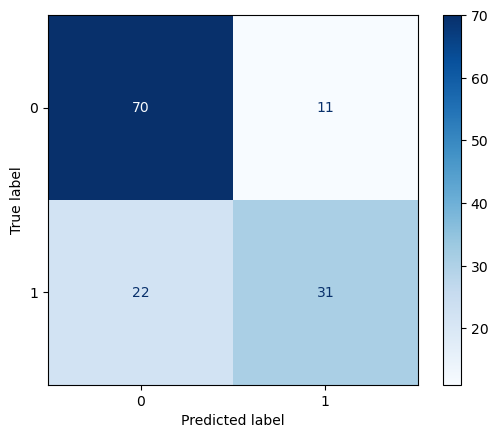

In [63]:
# Make a set of predictions for the validation data
y_pred_xg = my_tuned_xgboost.predict(Xt_valid)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred_xg) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["tuned_xgboost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_valid, y_pred_xg))

# Print confusion matrix
print("Confusion Matrix")
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_xg, cmap = 'Blues')

### Catboost

In [64]:
my_catb = CatBoostClassifier(verbose = 0)
my_catb.fit(Xt_train, y_train.values.ravel())

In [65]:
y_valid_catb=my_catb.predict(Xt_valid)
accuracy_score(y_valid, y_valid_catb)

0.7611940298507462

In [66]:
# Set up the parameter grid to seaerch
param_grid_Cat = [
 {
     'eval_metric':['BalancedAccuracy'] ,\
    'learning_rate': [.01,.03,.05,.1,.25],\
    'n_estimators': [10, 50, 100, 300,500],\
    'max_depth': [1,2, 4, 6, 8, 10], \
    'random_state':[0]}
]

# Perform the search
my_tuned_catb = sklearn.model_selection.GridSearchCV(CatBoostClassifier(verbose = 0),\
                                                      param_grid=param_grid_Cat, cv=cv_folds, verbose = 3, n_jobs = -1,scoring='balanced_accuracy')
my_tuned_catb.fit(Xt_train, y_train.values.ravel(),use_best_model=True, eval_set=(Xt_valid, y_valid.values.ravel()))

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
[CV 7/10] END learning_rate=0.05, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.809 total time=   0.0s
[CV 8/10] END learning_rate=0.05, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.804 total time=   0.0s
[CV 9/10] END learning_rate=0.05, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.835 total time=   0.0s
[CV 10/10] END learning_rate=0.05, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.762 total time=   0.0s
[CV 3/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.779 total time=   0.0s
[CV 4/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.816 total time=   0.0s
[CV 5/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteer

[CV 4/10] END learning_rate=0.05, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.826 total time=   0.0s
[CV 5/10] END learning_rate=0.05, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.884 total time=   0.0s
[CV 6/10] END learning_rate=0.05, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.857 total time=   0.0s
[CV 5/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.2s
[CV 6/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.2s
[CV 7/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.2s
[CV 8/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.2s
[CV 9/10] END 

[CV 1/10] END learning_rate=0.05, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 2/10] END learning_rate=0.05, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 3/10] END learning_rate=0.05, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 4/10] END learning_rate=0.05, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 5/10] END learning_rate=0.05, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 6/10] END learning_rate=0.05, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.05, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.1s
[CV 10/10] END

[CV 10/10] END learning_rate=0.1, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.784 total time=   0.0s
[CV 5/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.851 total time=   0.0s
[CV 6/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.0s
[CV 9/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.788 total time=   0.0s
[CV 10/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.771 total time=   0.0s
[CV 7/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.835 total time=   0.0s
[CV 8/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.813 total time=   0.0s
[CV 9/10] END learning

[CV 6/10] END learning_rate=0.1, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.1s
[CV 7/10] END learning_rate=0.1, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.1s
[CV 8/10] END learning_rate=0.1, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.870 total time=   0.1s
[CV 5/10] END learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.1s
[CV 6/10] END learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.1s
[CV 7/10] END learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.1s
[CV 8/10] END learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.848 total time=   0.1s
[CV 1/10] END learning_rate

[CV 6/10] END learning_rate=0.25, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.1s
[CV 7/10] END learning_rate=0.25, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.840 total time=   0.1s
[CV 8/10] END learning_rate=0.25, max_depth=8, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.870 total time=   0.1s
[CV 7/10] END learning_rate=0.25, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.753 total time=   0.1s
[CV 8/10] END learning_rate=0.25, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.710 total time=   0.1s
[CV 9/10] END learning_rate=0.25, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.684 total time=   0.1s
[CV 10/10] END learning_rate=0.25, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.771 total time=   0.1s
[CV 4/10] E

[CV 3/10] END learning_rate=0.1, max_depth=6, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.773 total time=   0.1s
[CV 4/10] END learning_rate=0.1, max_depth=6, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.756 total time=   0.1s
[CV 5/10] END learning_rate=0.1, max_depth=6, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.720 total time=   0.1s
[CV 6/10] END learning_rate=0.1, max_depth=6, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.801 total time=   0.1s
[CV 3/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.876 total time=   0.3s
[CV 4/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.753 total time=   0.3s
[CV 5/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.728 total time=   0.3s
[CV 6/10] END

[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=2, n_estimators=10, random_state=0;, score=0.764 total time=   0.5s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=2, n_estimators=10, random_state=0;, score=0.788 total time=   0.5s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=2, n_estimators=50, random_state=0;, score=0.814 total time=   0.2s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=0;, score=0.764 total time=   1.0s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=2, n_estimators=500, random_state=0;, score=0.824 total time=   2.4s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=4, n_estimators=50, random_state=0;, score=0.764 total time=   0.4s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=4, n_estimators=50, random_state=0;, score=0.813 total time=   0.8s
[CV 

[CV 8/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 9/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.822 total time=   0.0s
[CV 10/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.762 total time=   0.0s
[CV 1/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.792 total time=   0.0s
[CV 2/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.764 total time=   0.0s
[CV 7/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.822 total time=   0.0s
[CV 8/10] END learning_rate=0.1, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.826 total time=   0.0s
[CV 9/10] END lear

[CV 3/10] END learning_rate=0.25, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.789 total time=   0.0s
[CV 4/10] END learning_rate=0.25, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.816 total time=   0.0s
[CV 5/10] END learning_rate=0.25, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.826 total time=   0.0s
[CV 6/10] END learning_rate=0.25, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.753 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.754 total time=   0.1s
[CV 2/10] END learning_rate=0.25, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.748 total time=   0.2s
[CV 3/10] END learning_rate=0.25, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.1s
[CV 4/10] END le

[CV 10/10] END learning_rate=0.1, max_depth=10, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.798 total time=   0.3s
[CV 1/10] END learning_rate=0.1, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.742 total time=   0.4s
[CV 2/10] END learning_rate=0.1, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.708 total time=   0.4s
[CV 9/10] END learning_rate=0.25, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=8, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.754 total time=   0.1s
[CV 2/10] END learning_rate=0.25, max_depth=8, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.729 total time=   0.1s
[CV 7/10] END 

[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=4, n_estimators=300, random_state=0;, score=0.822 total time=   2.6s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=6, n_estimators=10, random_state=0;, score=0.823 total time=   0.3s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=6, n_estimators=10, random_state=0;, score=0.813 total time=   0.5s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=6, n_estimators=50, random_state=0;, score=0.823 total time=   0.8s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=0;, score=0.813 total time=   1.1s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=6, n_estimators=300, random_state=0;, score=0.813 total time=   2.6s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=8, n_estimators=10, random_state=0;, score=0.739 total time=   0.4s
[CV

[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=8, n_estimators=300, random_state=0;, score=0.789 total time=   7.4s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=10, n_estimators=300, random_state=0;, score=0.814 total time=   7.0s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=1, n_estimators=10, random_state=0;, score=0.831 total time=   0.6s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=1, n_estimators=50, random_state=0;, score=0.811 total time=   0.2s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=1, n_estimators=50, random_state=0;, score=0.807 total time=   0.5s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=1, n_estimators=100, random_state=0;, score=0.824 total time=   0.9s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=1, n_estimators=500, random_state=0;, score=0.782 total time=   3.3s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f7fc81930a0>,
             n_jobs=-1,
             param_grid=[{'eval_metric': ['BalancedAccuracy'],
                          'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.25],
                          'max_depth': [1, 2, 4, 6, 8, 10],
                          'n_estimators': [10, 50, 100, 300, 500],
                          'random_state': [0]}],
             scoring='balanced_accuracy', verbose=3)

In [67]:
# Print details
print("Best parameters set found on development set:")
print(my_tuned_catb.best_params_)
print(my_tuned_catb.best_score_)

Best parameters set found on development set:
{'eval_metric': 'BalancedAccuracy', 'learning_rate': 0.25, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}
0.8276170568561871


Accuracy: 0.7611940298507462
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        81
           1       0.74      0.60      0.67        53

    accuracy                           0.76       134
   macro avg       0.76      0.73      0.74       134
weighted avg       0.76      0.76      0.76       134

Confusion Matrix


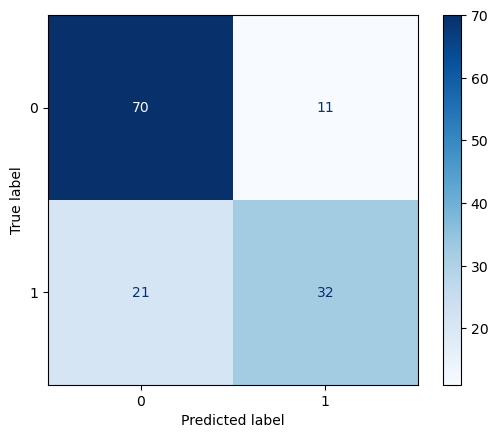

In [68]:
# Make a set of predictions for the validation data
y_pred_cat = my_tuned_catb.predict(Xt_valid)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred_cat) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["tuned_catb"] = accuracy
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_valid, y_pred_cat))

# Print confusion matrix
print("Confusion Matrix")
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_cat, cmap = 'Blues')

### SVC classifier

In [69]:
my_svc = SVC(probability=True)
my_svc.fit(Xt_train, y_train.values.ravel())

SVC(probability=True)

In [70]:
y_valid_svc=my_svc.predict(Xt_valid)
accuracy_score(y_valid, y_valid_svc)

0.7388059701492538

In [71]:
# Set up the parameter grid to seaerch
param_grid_svc = [
 {
    'kernel': ['rbf','linear'],\
    'gamma': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],\
    'C': [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1], \
    'random_state':[0]}
]

# Perform the search
my_tuned_svc = sklearn.model_selection.GridSearchCV(SVC(probability=True),\
                                                      param_grid=param_grid_svc, cv=cv_folds, verbose = 3, n_jobs = -1,scoring='balanced_accuracy')
my_tuned_svc.fit(Xt_train, y_train.values.ravel())

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=10, random_state=0;, score=0.763 total time=   0.7s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=50, random_state=0;, score=0.763 total time=   0.8s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=100, random_state=0;, score=0.822 total time=   0.2s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=300, random_state=0;, score=0.836 total time=   3.0s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=10, random_state=0;, score=0.813 total time=   0.5s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=50, random_state=0;, score=0.866 total time=   0.7s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_

[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=10, random_state=0;, score=0.760 total time=   0.9s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=10, random_state=0;, score=0.866 total time=   0.5s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=10, random_state=0;, score=0.776 total time=   0.6s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=50, random_state=0;, score=0.857 total time=   1.6s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=100, random_state=0;, score=0.866 total time=   3.8s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=500, random_state=0;, score=0.840 total time=  15.1s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=0;, score=0.813 total time=   6.

[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=6, n_estimators=500, random_state=0;, score=0.797 total time=   6.3s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=0;, score=0.853 total time=   5.6s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=300, random_state=0;, score=0.760 total time=  12.7s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=500, random_state=0;, score=0.739 total time=   2.6s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.776 total time=   0.3s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=50, random_state=0;, score=0.884 total time=   0.5s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=0;, score=0.739 total time=   0.7s
[CV

[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=500, random_state=0;, score=0.835 total time=  11.7s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.845 total time=   0.1s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.866 total time=   0.2s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.822 total time=   0.5s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=50, random_state=0;, score=0.813 total time=   0.6s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=100, random_state=0;, score=0.851 total time=   0.5s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=300, random_state=0;, score=0.795 total time=   0.7s
[CV 2/10

[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=6, n_estimators=100, random_state=0;, score=0.813 total time=   0.9s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=6, n_estimators=300, random_state=0;, score=0.789 total time=   4.4s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=50, random_state=0;, score=0.823 total time=   1.0s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=100, random_state=0;, score=0.822 total time=   1.2s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=0;, score=0.760 total time=   9.3s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=500, random_state=0;, score=0.814 total time=  12.3s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.857 total time=   0.2s
[

[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=100, random_state=0;, score=0.791 total time=   1.0s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=100, random_state=0;, score=0.785 total time=   0.7s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=300, random_state=0;, score=0.836 total time=   3.9s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=500, random_state=0;, score=0.822 total time=   3.1s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=0;, score=0.795 total time=   4.9s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=4, n_estimators=500, random_state=0;, score=0.820 total time=   5.5s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=6, n_estimators=500, random_state=0;, score=0.826 total time=   5.4s
[CV 3

[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=100, random_state=0;, score=0.853 total time=   0.7s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=500, random_state=0;, score=0.795 total time=   4.4s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=300, random_state=0;, score=0.814 total time=   2.7s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=6, n_estimators=10, random_state=0;, score=0.884 total time=   0.4s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=6, n_estimators=10, random_state=0;, score=0.776 total time=   0.4s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=6, n_estimators=50, random_state=0;, score=0.844 total time=   0.4s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=6, n_estimators=100, random_state=0;, score=0.857 total time=   0.9s
[

[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=8, n_estimators=500, random_state=0;, score=0.824 total time=  10.7s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=10, n_estimators=500, random_state=0;, score=0.789 total time=   7.3s
[CV 10/10] END C=0.05, gamma=0.1, kernel=linear, random_state=0;, score=0.763 total time=   0.0s
[CV 7/10] END C=0.05, gamma=0.2, kernel=linear, random_state=0;, score=0.814 total time=   0.0s
[CV 3/10] END C=0.05, gamma=0.4, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 4/10] END C=0.05, gamma=0.4, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 3/10] END C=0.05, gamma=0.6, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.05, gamma=0.6, kernel=linear, random_state=0;, score=0.824 total time=   0.0s
[CV 1/10] END C=0.05, gamma=0.9, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 2/10] END C=0.05, gamma=0.9, kernel=rbf, ran

[CV 9/10] END C=0.2, gamma=0.1, kernel=linear, random_state=0;, score=0.822 total time=   0.0s
[CV 10/10] END C=0.2, gamma=0.1, kernel=linear, random_state=0;, score=0.763 total time=   0.0s
[CV 9/10] END C=0.2, gamma=0.4, kernel=rbf, random_state=0;, score=0.779 total time=   0.1s
[CV 10/10] END C=0.2, gamma=0.4, kernel=rbf, random_state=0;, score=0.767 total time=   0.1s
[CV 1/10] END C=0.2, gamma=0.4, kernel=linear, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END C=0.2, gamma=0.4, kernel=linear, random_state=0;, score=0.773 total time=   0.0s
[CV 3/10] END C=0.2, gamma=0.8, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.2, gamma=0.8, kernel=linear, random_state=0;, score=0.824 total time=   0.0s
[CV 5/10] END C=0.2, gamma=0.8, kernel=linear, random_state=0;, score=0.859 total time=   0.0s
[CV 6/10] END C=0.2, gamma=0.8, kernel=linear, random_state=0;, score=0.857 total time=   0.0s
[CV 3/10] END C=0.3, gamma=0.1, kernel=linear, random_

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7,
                                0.8, 0.9, 1],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    1.0],
                          'kernel': ['rbf', 'linear'], 'random_state': [0]}],
             scoring='balanced_accuracy', verbose=3)

In [72]:
# Print details
print("Best parameters set found on development set:")
print(my_tuned_svc.best_params_)
print(my_tuned_svc.best_score_)

Best parameters set found on development set:
{'C': 0.6, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 0}
0.819628053106314


Accuracy: 0.7388059701492538
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        81
           1       0.69      0.62      0.65        53

    accuracy                           0.74       134
   macro avg       0.73      0.72      0.72       134
weighted avg       0.74      0.74      0.74       134

Confusion Matrix


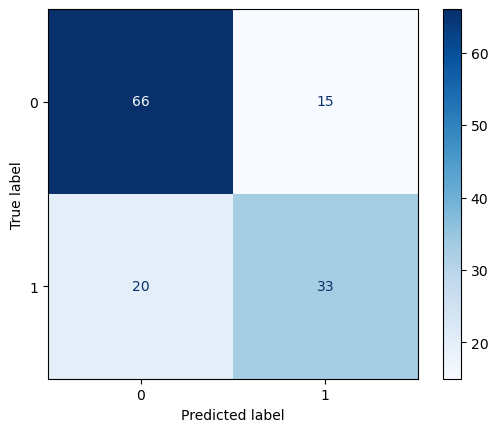

In [73]:
# Make a set of predictions for the validation data
y_pred_svc = my_tuned_svc.predict(Xt_valid)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred_svc) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["tuned_svc"] = accuracy
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_valid, y_pred_svc))

# Print confusion matrix
print("Confusion Matrix")
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_svc, cmap = 'Blues')
None

## Comparing models

In [74]:
display(model_valid_accuracy_comparisons)

{'tuned_rfc': 0.753731343283582,
 'tuned_xgboost': 0.753731343283582,
 'tuned_catb': 0.7611940298507462,
 'tuned_svc': 0.7388059701492538}

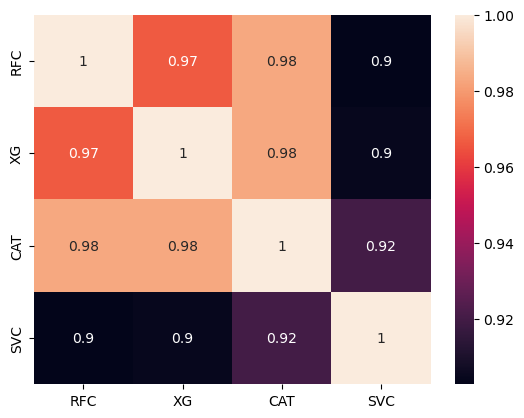

In [75]:
# Concatenate all classifier results
model_results = pd.concat([pd.Series(y_pred_rfc, name="RFC"),
                           pd.Series(y_pred_xg, name="XG"),
                           pd.Series(y_pred_cat, name="CAT"),
                           pd.Series(y_pred_svc, name="SVC")],axis=1)
heatmap= sns.heatmap(model_results.corr(),annot=True)

Accuracy quite similar and there is slight disagreement in results so will ensamble them with voting classifier 

In [76]:
classifiers=[('RFC',my_tuned_rfc),
             ('XGBoost',my_tuned_xgboost),
             ('CatBoost',my_tuned_catb),
             ('SVC',my_tuned_svc)]
vc = VotingClassifier(estimators=classifiers, voting='soft')

In [77]:
vc.fit(Xt_train, y_train.values.ravel())

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
[CV 9/10] END C=0.3, gamma=0.8, kernel=rbf, random_state=0;, score=0.783 total time=   0.1s
[CV 10/10] END C=0.3, gamma=0.8, kernel=rbf, random_state=0;, score=0.588 total time=   0.1s
[CV 1/10] END C=0.3, gamma=0.8, kernel=linear, random_state=0;, score=0.739 total time=   0.1s
[CV 2/10] END C=0.3, gamma=0.8, kernel=linear, random_state=0;, score=0.751 total time=   0.0s
[CV 1/10] END C=0.25, gamma=0.2, kernel=rbf, random_state=0;, score=0.766 total time=   0.1s
[CV 2/10] END C=0.25, gamma=0.2, kernel=rbf, random_state=0;, score=0.723 total time=   0.1s
[CV 3/10] END C=0.25, gamma=0.2, kernel=rbf, random_state=0;, score=0.810 total time=   0.1s
[CV 4/10] END C=0.25, gamma=0.2, kernel=rbf, random_state=0;, score=0.809 total time=   0.1s
[CV 9/10] END C=0.25, gamma=0.6, kernel=rbf, random_state=0;, score=0.804 total time=   0.1s
[CV 10/10] END C=0.25, gamma=0.6, kernel=rbf, random_state=0;, score=0.597 total time=   0.1s
[

[CV 3/10] END C=0.3, gamma=0.6, kernel=rbf, random_state=0;, score=0.758 total time=   0.1s
[CV 4/10] END C=0.3, gamma=0.6, kernel=rbf, random_state=0;, score=0.801 total time=   0.1s
[CV 7/10] END C=0.3, gamma=1.0, kernel=linear, random_state=0;, score=0.814 total time=   0.0s
[CV 8/10] END C=0.3, gamma=1.0, kernel=linear, random_state=0;, score=0.800 total time=   0.0s
[CV 9/10] END C=0.3, gamma=1.0, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.3, gamma=1.0, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 1/10] END C=0.25, gamma=0.4, kernel=rbf, random_state=0;, score=0.686 total time=   0.1s
[CV 2/10] END C=0.25, gamma=0.4, kernel=rbf, random_state=0;, score=0.723 total time=   0.1s
[CV 3/10] END C=0.25, gamma=0.4, kernel=rbf, random_state=0;, score=0.758 total time=   0.1s
[CV 4/10] END C=0.25, gamma=0.4, kernel=rbf, random_state=0;, score=0.797 total time=   0.1s
[CV 1/10] END C=0.25, gamma=0.9, kernel=rbf, random_state=0;, s

[CV 2/10] END C=0.3, gamma=0.4, kernel=linear, random_state=0;, score=0.751 total time=   0.1s
[CV 7/10] END C=0.3, gamma=0.8, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.3, gamma=0.8, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.3, gamma=0.8, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.3, gamma=0.8, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 9/10] END C=0.25, gamma=0.2, kernel=rbf, random_state=0;, score=0.809 total time=   0.1s
[CV 10/10] END C=0.25, gamma=0.2, kernel=rbf, random_state=0;, score=0.763 total time=   0.1s
[CV 1/10] END C=0.25, gamma=0.2, kernel=linear, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END C=0.25, gamma=0.2, kernel=linear, random_state=0;, score=0.751 total time=   0.0s
[CV 3/10] END C=0.25, gamma=0.6, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.25, gamma=0.6, kernel=linear, r

[CV 9/10] END C=0.5, gamma=0.3, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.5, gamma=0.3, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 9/10] END C=0.5, gamma=0.7, kernel=rbf, random_state=0;, score=0.827 total time=   0.1s
[CV 10/10] END C=0.5, gamma=0.7, kernel=rbf, random_state=0;, score=0.732 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.7, kernel=linear, random_state=0;, score=0.739 total time=   0.1s
[CV 2/10] END C=0.5, gamma=0.7, kernel=linear, random_state=0;, score=0.751 total time=   0.1s
[CV 5/10] END C=0.6, gamma=0.2, kernel=rbf, random_state=0;, score=0.814 total time=   0.1s
[CV 6/10] END C=0.6, gamma=0.2, kernel=rbf, random_state=0;, score=0.778 total time=   0.1s
[CV 7/10] END C=0.6, gamma=0.2, kernel=rbf, random_state=0;, score=0.818 total time=   0.1s
[CV 8/10] END C=0.6, gamma=0.2, kernel=rbf, random_state=0;, score=0.800 total time=   0.1s
[CV 3/10] END C=0.6, gamma=0.6, kernel=linear, random_state=0;, sc

[CV 8/10] END C=0.4, gamma=0.4, kernel=linear, random_state=0;, score=0.800 total time=   0.0s
[CV 9/10] END C=0.4, gamma=0.4, kernel=linear, random_state=0;, score=0.822 total time=   0.0s
[CV 10/10] END C=0.4, gamma=0.4, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 7/10] END C=0.4, gamma=0.8, kernel=linear, random_state=0;, score=0.814 total time=   0.0s
[CV 8/10] END C=0.4, gamma=0.8, kernel=linear, random_state=0;, score=0.800 total time=   0.0s
[CV 9/10] END C=0.4, gamma=0.8, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.4, gamma=0.8, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 3/10] END C=0.5, gamma=0.1, kernel=linear, random_state=0;, score=0.810 total time=   0.1s
[CV 4/10] END C=0.5, gamma=0.1, kernel=linear, random_state=0;, score=0.824 total time=   0.1s
[CV 5/10] END C=0.5, gamma=0.1, kernel=linear, random_state=0;, score=0.859 total time=   0.1s
[CV 6/10] END C=0.5, gamma=0.1, kernel=linear, r

[CV 3/10] END C=0.4, gamma=0.3, kernel=rbf, random_state=0;, score=0.810 total time=   0.1s
[CV 4/10] END C=0.4, gamma=0.3, kernel=rbf, random_state=0;, score=0.809 total time=   0.1s
[CV 5/10] END C=0.4, gamma=0.7, kernel=rbf, random_state=0;, score=0.791 total time=   0.1s
[CV 6/10] END C=0.4, gamma=0.7, kernel=rbf, random_state=0;, score=0.789 total time=   0.1s
[CV 7/10] END C=0.4, gamma=0.7, kernel=rbf, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.4, gamma=0.7, kernel=rbf, random_state=0;, score=0.779 total time=   0.1s
[CV 9/10] END C=0.5, gamma=0.2, kernel=rbf, random_state=0;, score=0.809 total time=   0.1s
[CV 10/10] END C=0.5, gamma=0.2, kernel=rbf, random_state=0;, score=0.776 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.2, kernel=linear, random_state=0;, score=0.739 total time=   0.1s
[CV 2/10] END C=0.5, gamma=0.2, kernel=linear, random_state=0;, score=0.751 total time=   0.1s
[CV 3/10] END C=0.5, gamma=0.6, kernel=linear, random_state=0;, score=0.8

[CV 7/10] END C=0.5, gamma=0.3, kernel=rbf, random_state=0;, score=0.818 total time=   0.1s
[CV 8/10] END C=0.5, gamma=0.3, kernel=rbf, random_state=0;, score=0.797 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.7, kernel=rbf, random_state=0;, score=0.760 total time=   0.1s
[CV 2/10] END C=0.5, gamma=0.7, kernel=rbf, random_state=0;, score=0.723 total time=   0.1s
[CV 3/10] END C=0.5, gamma=0.7, kernel=rbf, random_state=0;, score=0.823 total time=   0.1s
[CV 4/10] END C=0.5, gamma=0.7, kernel=rbf, random_state=0;, score=0.799 total time=   0.1s
[CV 1/10] END C=0.6, gamma=0.1, kernel=rbf, random_state=0;, score=0.770 total time=   0.1s
[CV 2/10] END C=0.6, gamma=0.1, kernel=rbf, random_state=0;, score=0.760 total time=   0.1s
[CV 3/10] END C=0.6, gamma=0.1, kernel=rbf, random_state=0;, score=0.866 total time=   0.1s
[CV 4/10] END C=0.6, gamma=0.1, kernel=rbf, random_state=0;, score=0.847 total time=   0.1s
[CV 3/10] END C=0.6, gamma=0.4, kernel=linear, random_state=0;, score=0.810 tota

[CV 10/10] END C=0.8, gamma=0.6, kernel=rbf, random_state=0;, score=0.776 total time=   0.1s
[CV 1/10] END C=0.8, gamma=0.6, kernel=linear, random_state=0;, score=0.739 total time=   0.1s
[CV 2/10] END C=0.8, gamma=0.6, kernel=linear, random_state=0;, score=0.751 total time=   0.1s
[CV 7/10] END C=0.8, gamma=0.9, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.8, gamma=0.9, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.8, gamma=0.9, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.8, gamma=0.9, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 3/10] END C=0.9, gamma=0.3, kernel=linear, random_state=0;, score=0.810 total time=   0.1s
[CV 4/10] END C=0.9, gamma=0.3, kernel=linear, random_state=0;, score=0.824 total time=   0.1s
[CV 5/10] END C=0.9, gamma=0.3, kernel=linear, random_state=0;, score=0.859 total time=   0.1s
[CV 6/10] END C=0.9, gamma=0.3, kernel=linear, rand

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.756 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.820 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.824 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.884 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.857 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_featu

[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.785 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.822 total time=   0.3s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.745 total time=   0.3s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500, random_state=0;, score=0.776 total time=   0.6s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500, random_state=0;, score=0.751 total time=   0.6s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.841 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.756 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.823 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.859 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.884 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_de

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.754 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.779 total time=   0.3s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.826 total time=   0.3s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.841 total time=   0.3s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.756 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, 

[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.751 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.841 total time=   0.3s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.841 total time=   0.6s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.756 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.789 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_fea

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.776 total time=   0.6s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.751 total time=   0.6s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.866 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.826 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=2, 

[CV 6/10] END C=0.9, gamma=1.0, kernel=rbf, random_state=0;, score=0.776 total time=   0.1s
[CV 7/10] END C=0.9, gamma=1.0, kernel=rbf, random_state=0;, score=0.802 total time=   0.1s
[CV 8/10] END C=0.9, gamma=1.0, kernel=rbf, random_state=0;, score=0.814 total time=   0.1s
[CV 5/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.791 total time=   0.1s
[CV 6/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.814 total time=   0.1s
[CV 7/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.827 total time=   0.1s
[CV 8/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.831 total time=   0.1s
[CV 9/10] END C=1, gamma=0.8, kernel=rbf, random_state=0;, score=0.827 total time=   0.1s
[CV 10/10] END C=1, gamma=0.8, kernel=rbf, random_state=0;, score=0.754 total time=   0.1s
[CV 1/10] END C=1, gamma=0.8, kernel=linear, random_state=0;, score=0.739 total time=   0.1s
[CV 2/10] END C=1, gamma=0.8, kernel=linear, random_state=0;, score=0.751 total time=   0.

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.822 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.853 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.853 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.773 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.773 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.841 total time=   0.6s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.756 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.776 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.729 total time=   0.3s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.779 total time=   0.3s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, m

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.776 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.845 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.782 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.800 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.782 total time=   0.6s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4,

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.782 total time=   0.4s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.782 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.866 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.859 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.773 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_dept

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.782 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.801 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.782 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.822 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.822 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_dep

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.841 total time=   0.3s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.756 total time=   0.3s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.841 total time=   0.3s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.756 total time=   0.3s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.866 total time=   0.3s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, m

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.776 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.822 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.813 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.874 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.847 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.828 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.801 total time=   0.4s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.861 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.801 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.813 total time=   0.4s
[CV 8/10] END bootstrap=False, criterion=gini, max_

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.844 total time=   0.4s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.813 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.844 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.844 total time=   0.4s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.800 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_dep

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.739 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.836 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.776 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.813 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.853 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.767 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.835 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.784 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.835 total time=   0.4s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.767 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_featu

[CV 4/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.814 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.847 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.822 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.801 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.828 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=8, max_fea

[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.773 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.814 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.798 total time=   0.0s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.773 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=0;, score=0.813 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=8, max_

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.835 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.836 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=0;, score=0.814 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.801 total time=   0.4s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.776 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, 

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.813 total time=   0.4s
[CV 7/10] END learning_rate=0.01, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.0s
[CV 7/10] END learning_rate=0.01, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.0s
[CV 7/10] END learning_rate=0.01, max_depth=1, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.0s
[CV 8/10] END learning_rate=0.01, max_depth=1, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.788 total time=   0.0s
[CV 3/10] END learning_rate=0.01, max_depth=2, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.727 total time=   0.0s
[CV 4/10] END learning_rate=0.01, max_depth=2, n_estimators=10, objective=binary:logistic, random_state=0;, score

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.874 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.814 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.814 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.814 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.814 total time=   0.6s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, 

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.784 total time=   0.4s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.813 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.844 total time=   0.2s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.813 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.845 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_d

[CV 6/10] END learning_rate=0.01, max_depth=2, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 3/10] END learning_rate=0.01, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.727 total time=   0.0s
[CV 4/10] END learning_rate=0.01, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.783 total time=   0.0s
[CV 5/10] END learning_rate=0.01, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.773 total time=   0.0s
[CV 6/10] END learning_rate=0.01, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.795 total time=   0.0s
[CV 1/10] END learning_rate=0.01, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.0s
[CV 2/10] END learning_rate=0.01, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.0s
[CV 3/10] END l

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.801 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.847 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.822 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.801 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=0;, score=0.813 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.813 total time=   0.2s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.758 total time=   0.4s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=0;, score=0.767 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.758 total time=   0.4s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.844 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_de

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.813 total time=   0.6s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.813 total time=   0.6s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500, random_state=0;, score=0.822 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=0;, score=0.789 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.789 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_dept

[CV 1/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 2/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 3/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 4/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 5/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 6/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.1s
[CV 10/10] END

[CV 7/10] END learning_rate=0.01, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 7/10] END learning_rate=0.01, max_depth=1, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 3/10] END learning_rate=0.01, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.820 total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.811 total time=   0.1s
[CV 9/10] END learning_rate=0.01, max_depth=4, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.818 total time=   0.0s
[CV 10/10] END learning_rate=0.01, max_depth=4, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.763 total time=   0.0s
[CV 1/10] END learning_rate=0.01, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 2/10] END 

[CV 6/10] END learning_rate=0.01, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.849 total time=   0.1s
[CV 7/10] END learning_rate=0.01, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.866 total time=   0.1s
[CV 8/10] END learning_rate=0.01, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.813 total time=   0.1s
[CV 3/10] END learning_rate=0.01, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.1s
[CV 5/10] END learning_rate=0.01, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.1s
[CV 6/10] END learning_rate=0.01, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.1s
[CV 7/10] EN

[CV 5/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.847 total time=   0.0s
[CV 6/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.807 total time=   0.0s
[CV 7/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.0s
[CV 8/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.788 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.759 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=1, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END learning_r

[CV 3/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.823 total time=   0.2s
[CV 4/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.826 total time=   0.2s
[CV 5/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.828 total time=   0.2s
[CV 6/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.801 total time=   0.2s
[CV 7/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.844 total time=   0.2s
[CV 8/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.835 total time=   0.2s
[CV 9/10] END learning_rate=0.03, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.822 total time=   0.2s
[CV 10

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.853 total time=   0.3s
[CV 4/10] END learning_rate=0.01, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 4/10] END learning_rate=0.01, max_depth=1, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.01, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.1s
[CV 10/10] END learning_rate=0.01, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.776 total time=   0.1s
[CV 7/10] END learning_rate=0.01, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 8/10] END learning_rate=0.01, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=

[CV 8/10] END learning_rate=0.03, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.762 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.814 total time=   0.0s
[CV 2/10] END learning_rate=0.03, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.801 total time=   0.0s
[CV 3/10] END learning_rate=0.03, max_depth=8, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.779 total time=   0.1s
[CV 4/10] END learning_rate=0.03, max_depth=8, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.778 total time=   0.1s
[CV 5/10] END lear

[CV 1/10] END learning_rate=0.05, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.795 total time=   0.1s
[CV 2/10] END learning_rate=0.05, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.739 total time=   0.1s
[CV 3/10] END learning_rate=0.05, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.823 total time=   0.1s
[CV 4/10] END learning_rate=0.05, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.803 total time=   0.1s
[CV 5/10] END learning_rate=0.05, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.828 total time=   0.1s
[CV 6/10] END learning_rate=0.05, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.776 total time=   0.1s
[CV 9/10] END learning_rate=0.05, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10

[CV 10/10] END learning_rate=0.03, max_depth=2, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.776 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=2, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END learning_rate=0.03, max_depth=2, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.764 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=2, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=2, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.776 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END learning_rate=0.03, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.764 total time=   0.0s
[CV 3/10] END

[CV 7/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.0s
[CV 8/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 9/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.827 total time=   0.0s
[CV 1/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.789 total time=   0.0s
[CV 2/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.764 total time=   0.0s
[CV 5/10] END learning_rate=0.05, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.1s
[CV 6/10] END learning

[CV 10/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.823 total time=   0.1s
[CV 1/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.779 total time=   0.2s
[CV 2/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.820 total time=   0.2s
[CV 3/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.879 total time=   0.2s
[CV 4/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.791 total time=   0.2s
[CV 5/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.778 total time=   0.2s
[CV 6/10] END learning_rate=0.05, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.778 total time=   0.2s


[CV 5/10] END learning_rate=0.05, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.756 total time=   0.4s
[CV 6/10] END learning_rate=0.05, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.768 total time=   0.4s
[CV 7/10] END learning_rate=0.05, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.809 total time=   0.3s
[CV 8/10] END learning_rate=0.05, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.822 total time=   0.4s
[CV 9/10] END learning_rate=0.05, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.822 total time=   0.4s
[CV 10/10] END learning_rate=0.05, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.693 total time=   0.4s
[CV 9/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.0s
[CV 10/1

[CV 9/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.759 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.764 total time=   0.0s
[CV 3/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.820 total time=   0.0s
[CV 4/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.811 total time=   0.0s
[CV 5/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.847 total time=   0.0s
[CV 6/10] END le

[CV 5/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.1s
[CV 6/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.1s
[CV 7/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.818 total time=   0.1s
[CV 8/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.1s
[CV 1/10] END learning_rate=0.25, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.0s
[CV 2/10] END learning_rate=0.25, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.751 total time=   0.0s
[CV 3/10] END learning_rate=0.25, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.845 total time=   0.0s
[CV 4/10] END learning_

[CV 2/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.764 total time=   0.0s
[CV 3/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.823 total time=   0.0s
[CV 4/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.803 total time=   0.0s
[CV 5/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.0s
[CV 6/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.0s
[CV 7/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.0s
[CV 8/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 7/10] END learning_rate=0.1, m

[CV 7/10] END learning_rate=0.1, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.1s
[CV 8/10] END learning_rate=0.1, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.1s
[CV 3/10] END learning_rate=0.1, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.773 total time=   0.2s
[CV 4/10] END learning_rate=0.1, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.745 total time=   0.2s
[CV 5/10] END learning_rate=0.1, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.698 total time=   0.3s
[CV 6/10] END learning_rate=0.1, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.778 total time=   0.2s
[CV 7/10] END learning_rate=0.1, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.827 total time=   0.2s
[CV 8/10] END lea

[CV 5/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 6/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.824 total time=   0.0s
[CV 7/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.0s
[CV 8/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.776 total time=   0.1s
[CV 2/10] END learning_rate=0.25, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.760 total time=   0.1s
[CV 3/10] END learning_rate=0.25, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.1s
[CV 4/10] END learning_r

[CV 5/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.814 total time=   0.1s
[CV 6/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.789 total time=   0.1s
[CV 7/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.1s
[CV 8/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.870 total time=   0.1s
[CV 5/10] END learning_rate=0.25, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.1s
[CV 6/10] END learning_rate=0.25, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.801 total time=   0.1s
[CV 7/10] END learning_rate=0.25, max_depth=2, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.1s
[CV 8/10] END learni

[CV 2/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.748 total time=   0.2s
[CV 3/10] END learning_rate=0.05, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.888 total time=   0.4s
[CV 4/10] END learning_rate=0.05, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.778 total time=   0.4s
[CV 5/10] END learning_rate=0.05, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.791 total time=   0.4s
[CV 6/10] END learning_rate=0.05, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.733 total time=   0.5s
[CV 7/10] END learning_rate=0.05, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.809 total time=   0.5s
[CV 8/10] END learning_rate=0.05, max_depth=10, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.788 total time=   0.5s


[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=6, n_estimators=500, random_state=0;, score=0.813 total time=   4.6s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=8, n_estimators=500, random_state=0;, score=0.764 total time=   8.0s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=10, n_estimators=500, random_state=0;, score=0.751 total time=  10.5s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=50, random_state=0;, score=0.845 total time=   0.9s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=100, random_state=0;, score=0.813 total time=   0.7s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=500, random_state=0;, score=0.773 total time=   2.1s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=10, random_state=0;, score=0.764 total time=   0.4s


[CV 8/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.826 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.776 total time=   0.1s
[CV 3/10] END learning_rate=0.25, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.866 total time=   0.1s
[CV 7/10] END learning_rate=0.25, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.818 total time=   0.1s
[CV 4/10] END learning_rate=0.25, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.720 total time=   0.1s
[CV 4/10] END learning_rate=0.25, max_depth=10, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.768 total time=   0.4s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.01, max_depth=1, n_estimators=10, random_state=0;, score=0.811 total time=   0.3s
[CV 4/10] E

[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=500, random_state=0;, score=0.835 total time=   3.3s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=50, random_state=0;, score=0.857 total time=   1.1s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=100, random_state=0;, score=0.780 total time=   1.8s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=300, random_state=0;, score=0.813 total time=   6.8s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=50, random_state=0;, score=0.844 total time=   0.3s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=100, random_state=0;, score=0.845 total time=   0.6s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=300, random_state=0;, score=0.785 total time=   0.

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=100, random_state=0;, score=0.782 total time=   0.6s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=100, random_state=0;, score=0.844 total time=   0.6s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=300, random_state=0;, score=0.853 total time=   1.6s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=500, random_state=0;, score=0.853 total time=   3.6s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=2, n_estimators=100, random_state=0;, score=0.866 total time=   0.4s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=2, n_estimators=300, random_state=0;, score=0.826 total time=   4.5s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=4, 

[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=300, random_state=0;, score=0.751 total time=   2.7s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=10, random_state=0;, score=0.845 total time=   0.5s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=10, random_state=0;, score=0.844 total time=   0.4s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=50, random_state=0;, score=0.813 total time=   0.2s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=100, random_state=0;, score=0.764 total time=   0.7s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=300, random_state=0;, score=0.816 total time=   2.8s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=10, random_state=0;, score=0.857 total time=   0.3s
[CV

[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=100, random_state=0;, score=0.857 total time=   1.0s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=300, random_state=0;, score=0.835 total time=   4.2s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=10, random_state=0;, score=0.884 total time=   1.0s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=50, random_state=0;, score=0.801 total time=   0.8s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=100, random_state=0;, score=0.828 total time=   1.5s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=300, random_state=0;, score=0.791 total time=   3.4s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=500, random_state=0;, score=0.826 total time=   7

[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=50, random_state=0;, score=0.828 total time=   0.6s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=50, random_state=0;, score=0.800 total time=   0.3s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=100, random_state=0;, score=0.835 total time=   2.0s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=500, random_state=0;, score=0.764 total time=  10.1s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=500, random_state=0;, score=0.831 total time=  14.5s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=4, n_estimators=10, random_state=0;, score=0.836 total time=   0.3s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=4, n_estimators=10, random_state=0;, score=0.853 total time=   0.2s
[C

[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=300, random_state=0;, score=0.795 total time=   0.7s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=500, random_state=0;, score=0.776 total time=   4.1s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=4, n_estimators=300, random_state=0;, score=0.791 total time=   3.6s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=6, n_estimators=50, random_state=0;, score=0.828 total time=   0.7s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=6, n_estimators=100, random_state=0;, score=0.844 total time=   1.0s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=0;, score=0.780 total time=   3.4s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=8, n_estimators=50, random_state=0;, score=0.857 total time=   0.5s
[CV 4/1

[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=100, random_state=0;, score=0.789 total time=   0.8s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=300, random_state=0;, score=0.789 total time=   1.9s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=10, random_state=0;, score=0.804 total time=   0.2s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=10, random_state=0;, score=0.866 total time=   0.4s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=50, random_state=0;, score=0.851 total time=   0.5s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=100, random_state=0;, score=0.857 total time=   0.7s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=300, random_state=0;, score=0.844 total time=   3.2s


[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=300, random_state=0;, score=0.869 total time=   2.3s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=500, random_state=0;, score=0.822 total time=   5.0s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=500, random_state=0;, score=0.797 total time=   3.9s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=4, n_estimators=500, random_state=0;, score=0.844 total time=   5.3s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=6, n_estimators=500, random_state=0;, score=0.844 total time=   6.6s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=8, n_estimators=500, random_state=0;, score=0.789 total time=   6.9s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=10, n_estimators=300, random_state=0;, score=0.801 total time=   6.

[CV 8/10] END C=0.05, gamma=0.5, kernel=linear, random_state=0;, score=0.800 total time=   0.0s
[CV 1/10] END C=0.05, gamma=0.8, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 2/10] END C=0.05, gamma=0.8, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 3/10] END C=0.05, gamma=0.8, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 4/10] END C=0.05, gamma=0.8, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 3/10] END C=0.1, gamma=0.4, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.4, kernel=linear, random_state=0;, score=0.824 total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.4, kernel=linear, random_state=0;, score=0.836 total time=   0.0s
[CV 6/10] END C=0.1, gamma=0.4, kernel=linear, random_state=0;, score=0.857 total time=   0.0s
[CV 9/10] END C=0.1, gamma=0.7, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 10/10] END C=0.1, gamma=0.7, kernel=rbf, random_state=0;

[CV 2/10] END C=0.05, gamma=1.0, kernel=linear, random_state=0;, score=0.795 total time=   0.0s
[CV 3/10] END C=0.1, gamma=0.3, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.3, kernel=linear, random_state=0;, score=0.824 total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.3, kernel=linear, random_state=0;, score=0.836 total time=   0.0s
[CV 6/10] END C=0.1, gamma=0.3, kernel=linear, random_state=0;, score=0.857 total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.6, kernel=rbf, random_state=0;, score=0.523 total time=   0.1s
[CV 6/10] END C=0.1, gamma=0.6, kernel=rbf, random_state=0;, score=0.545 total time=   0.1s
[CV 7/10] END C=0.1, gamma=0.6, kernel=rbf, random_state=0;, score=0.565 total time=   0.1s
[CV 8/10] END C=0.1, gamma=0.6, kernel=rbf, random_state=0;, score=0.522 total time=   0.1s
[CV 3/10] END C=0.2, gamma=0.1, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.2, gamma=0.1, kernel=linear, random_state=0

[CV 3/10] END C=0.1, gamma=0.9, kernel=rbf, random_state=0;, score=0.522 total time=   0.1s
[CV 4/10] END C=0.1, gamma=0.9, kernel=rbf, random_state=0;, score=0.523 total time=   0.1s
[CV 7/10] END C=0.2, gamma=0.3, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.2, gamma=0.3, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.2, gamma=0.3, kernel=linear, random_state=0;, score=0.822 total time=   0.0s
[CV 10/10] END C=0.2, gamma=0.3, kernel=linear, random_state=0;, score=0.763 total time=   0.0s
[CV 9/10] END C=0.2, gamma=0.7, kernel=rbf, random_state=0;, score=0.630 total time=   0.1s
[CV 10/10] END C=0.2, gamma=0.7, kernel=rbf, random_state=0;, score=0.536 total time=   0.1s
[CV 1/10] END C=0.2, gamma=0.7, kernel=linear, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END C=0.2, gamma=0.7, kernel=linear, random_state=0;, score=0.773 total time=   0.0s
[CV 9/10] END C=0.3, gamma=0.1, kernel=rbf, random_state=0;,

[CV 3/10] END C=0.2, gamma=0.9, kernel=linear, random_state=0;, score=0.810 total time=   0.0s
[CV 4/10] END C=0.2, gamma=0.9, kernel=linear, random_state=0;, score=0.824 total time=   0.1s
[CV 5/10] END C=0.2, gamma=0.9, kernel=linear, random_state=0;, score=0.859 total time=   0.1s
[CV 6/10] END C=0.2, gamma=0.9, kernel=linear, random_state=0;, score=0.857 total time=   0.1s
[CV 1/10] END C=0.3, gamma=0.5, kernel=rbf, random_state=0;, score=0.664 total time=   0.1s
[CV 2/10] END C=0.3, gamma=0.5, kernel=rbf, random_state=0;, score=0.735 total time=   0.1s
[CV 3/10] END C=0.3, gamma=0.5, kernel=rbf, random_state=0;, score=0.779 total time=   0.1s
[CV 4/10] END C=0.3, gamma=0.5, kernel=rbf, random_state=0;, score=0.797 total time=   0.1s
[CV 3/10] END C=0.3, gamma=0.9, kernel=linear, random_state=0;, score=0.810 total time=   0.1s
[CV 4/10] END C=0.3, gamma=0.9, kernel=linear, random_state=0;, score=0.824 total time=   0.0s
[CV 5/10] END C=0.3, gamma=0.9, kernel=linear, random_state=0;

VotingClassifier(estimators=[('RFC',
                              GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                           estimator=RandomForestClassifier(),
                                           n_jobs=-1,
                                           param_grid={'bootstrap': [False],
                                                       'criterion': ['gini'],
                                                       'max_depth': [2, 4, 6, 8,
                                                                     10],
                                                       'max_features': ['log2'],
                                                       'min_samples_leaf': [5,
                                                                            10],
                                                       'min_samples_split': [5,
                                                                             10,
                                                                             0.03,
                                                                             0.05,
                                                                             0.1],
                                                       'n_estimators': [10, 50,
                                                                        1...
                                           verbose=3)),
                             ('SVC',
                              GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                           estimator=SVC(probability=True),
                                           n_jobs=-1,
                                           param_grid=[{'C': [0.05, 0.1, 0.2,
                                                              0.3, 0.25, 0.4,
                                                              0.5, 0.6, 0.7,
                                                              0.8, 0.9, 1],
                                                        'gamma': [0.1, 0.2, 0.3,
                                                                  0.4, 0.5, 0.6,
                                                                  0.7, 0.8, 0.9,
                                                                  1.0],
                                                        'kernel': ['rbf',
                                                                   'linear'],
                                                        'random_state': [0]}],
                                           scoring='balanced_accuracy',
                                           verbose=3))],
                 voting='soft')

Accuracy: 0.7611940298507462
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        81
           1       0.74      0.60      0.67        53

    accuracy                           0.76       134
   macro avg       0.76      0.73      0.74       134
weighted avg       0.76      0.76      0.76       134

Confusion Matrix


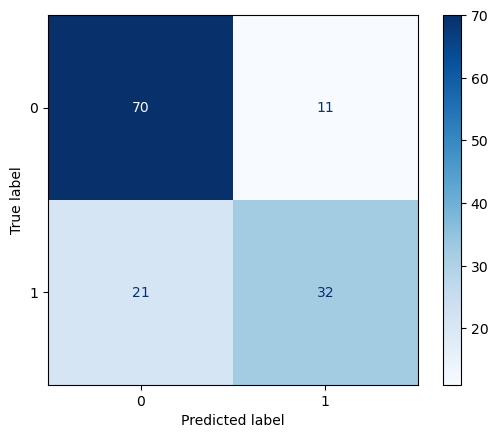

In [78]:
# Make a set of predictions for the validation data
y_pred = vc.predict(Xt_valid)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Voting_Classifier"] = accuracy
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, cmap = 'Blues')

In [79]:
display(model_valid_accuracy_comparisons)

{'tuned_rfc': 0.753731343283582,
 'tuned_xgboost': 0.753731343283582,
 'tuned_catb': 0.7611940298507462,
 'tuned_svc': 0.7388059701492538,
 'Voting_Classifier': 0.7611940298507462}

### Testing on hold-out dataset

Accuracy: 0.8208955223880597
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        72
           1       0.88      0.71      0.79        62

    accuracy                           0.82       134
   macro avg       0.83      0.81      0.82       134
weighted avg       0.83      0.82      0.82       134

Confusion Matrix


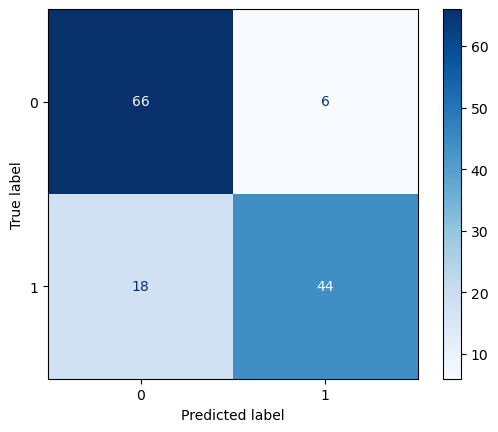

In [80]:
# Make a set of predictions for the hold-out data
y_pred = vc.predict(Xt_test)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues')

## Re-training with whole dataset

#### Applying transformations made after splits to unsplitted dataset

In [81]:
X_Imputed=imputer(X)
X_Imputed=bin_maker.bin(X_Imputed)
X_Imputed=bin_maker_fare.bin_quantile(X_Imputed)
X_efs = X_Imputed[selected_features]
X_efs = pd.DataFrame(scaler.fit_transform(X_efs), columns = X_efs.columns)

In [82]:
vc = VotingClassifier(estimators=classifiers, voting='soft')
vc.fit(X_efs, y.values.ravel())

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
[CV 9/10] END C=0.25, gamma=0.5, kernel=linear, random_state=0;, score=0.822 total time=   0.0s
[CV 10/10] END C=0.25, gamma=0.5, kernel=linear, random_state=0;, score=0.763 total time=   0.0s
[CV 1/10] END C=0.25, gamma=0.9, kernel=rbf, random_state=0;, score=0.609 total time=   0.1s
[CV 2/10] END C=0.25, gamma=0.9, kernel=rbf, random_state=0;, score=0.562 total time=   0.1s
[CV 3/10] END C=0.25, gamma=0.9, kernel=rbf, random_state=0;, score=0.596 total time=   0.1s
[CV 4/10] END C=0.25, gamma=0.9, kernel=rbf, random_state=0;, score=0.692 total time=   0.1s
[CV 1/10] END C=0.4, gamma=0.4, kernel=rbf, random_state=0;, score=0.760 total time=   0.1s
[CV 2/10] END C=0.4, gamma=0.4, kernel=rbf, random_state=0;, score=0.735 total time=   0.1s
[CV 3/10] END C=0.4, gamma=0.4, kernel=rbf, random_state=0;, score=0.845 total time=   0.1s
[CV 4/10] END C=0.4, gamma=0.4, kernel=rbf, random_state=0;, score=0.809 total time=   0.1s
[C

[CV 7/10] END C=0.4, gamma=0.6, kernel=linear, random_state=0;, score=0.814 total time=   0.0s
[CV 8/10] END C=0.4, gamma=0.6, kernel=linear, random_state=0;, score=0.800 total time=   0.0s
[CV 9/10] END C=0.4, gamma=0.6, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.4, gamma=0.6, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 7/10] END C=0.4, gamma=0.9, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.4, gamma=0.9, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.4, gamma=0.9, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.4, gamma=0.9, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 9/10] END C=0.5, gamma=0.3, kernel=rbf, random_state=0;, score=0.805 total time=   0.1s
[CV 10/10] END C=0.5, gamma=0.3, kernel=rbf, random_state=0;, score=0.780 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.3, kernel=linear, random

[CV 8/10] END C=0.9, gamma=0.5, kernel=rbf, random_state=0;, score=0.805 total time=   0.1s
[CV 7/10] END C=0.9, gamma=0.8, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.9, gamma=0.8, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.9, gamma=0.8, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.9, gamma=0.8, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 7/10] END C=1, gamma=0.2, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=1, gamma=0.2, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=1, gamma=0.2, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=1, gamma=0.2, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 7/10] END C=1, gamma=0.6, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=1, gamma=0.6, kernel=linear, random_state=0;,

[CV 9/10] END C=0.8, gamma=0.2, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.8, gamma=0.2, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 5/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.778 total time=   0.1s
[CV 6/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.776 total time=   0.1s
[CV 7/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.802 total time=   0.1s
[CV 8/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.814 total time=   0.1s
[CV 1/10] END C=0.9, gamma=0.1, kernel=rbf, random_state=0;, score=0.739 total time=   0.0s
[CV 2/10] END C=0.9, gamma=0.1, kernel=rbf, random_state=0;, score=0.773 total time=   0.0s
[CV 3/10] END C=0.9, gamma=0.1, kernel=rbf, random_state=0;, score=0.845 total time=   0.0s
[CV 4/10] END C=0.9, gamma=0.1, kernel=rbf, random_state=0;, score=0.847 total time=   0.0s
[CV 1/10] END C=0.9, gamma=0.3, kernel=rbf, random_state=0;, score=0.695 

[CV 7/10] END C=0.8, gamma=0.8, kernel=rbf, random_state=0;, score=0.802 total time=   0.1s
[CV 8/10] END C=0.8, gamma=0.8, kernel=rbf, random_state=0;, score=0.814 total time=   0.1s
[CV 3/10] END C=0.9, gamma=0.2, kernel=linear, random_state=0;, score=0.810 total time=   0.1s
[CV 4/10] END C=0.9, gamma=0.2, kernel=linear, random_state=0;, score=0.824 total time=   0.1s
[CV 5/10] END C=0.9, gamma=0.2, kernel=linear, random_state=0;, score=0.859 total time=   0.1s
[CV 6/10] END C=0.9, gamma=0.2, kernel=linear, random_state=0;, score=0.869 total time=   0.1s
[CV 7/10] END C=0.9, gamma=0.6, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.9, gamma=0.6, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.9, gamma=0.6, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.9, gamma=0.6, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 3/10] END C=0.9, gamma=1.0, kernel=linear, random_s

[CV 4/10] END C=0.7, gamma=0.9, kernel=linear, random_state=0;, score=0.824 total time=   0.1s
[CV 5/10] END C=0.7, gamma=0.9, kernel=linear, random_state=0;, score=0.859 total time=   0.1s
[CV 6/10] END C=0.7, gamma=0.9, kernel=linear, random_state=0;, score=0.857 total time=   0.1s
[CV 5/10] END C=0.8, gamma=0.3, kernel=rbf, random_state=0;, score=0.778 total time=   0.1s
[CV 6/10] END C=0.8, gamma=0.3, kernel=rbf, random_state=0;, score=0.778 total time=   0.1s
[CV 7/10] END C=0.8, gamma=0.3, kernel=rbf, random_state=0;, score=0.818 total time=   0.1s
[CV 8/10] END C=0.8, gamma=0.3, kernel=rbf, random_state=0;, score=0.788 total time=   0.1s
[CV 1/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.782 total time=   0.1s
[CV 2/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.748 total time=   0.1s
[CV 3/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.866 total time=   0.1s
[CV 4/10] END C=0.8, gamma=0.7, kernel=rbf, random_state=0;, score=0.79

[CV 7/10] END C=0.9, gamma=0.9, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=0.9, gamma=0.9, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=0.9, gamma=0.9, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=0.9, gamma=0.9, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 1/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.717 total time=   0.1s
[CV 2/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.748 total time=   0.1s
[CV 3/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.866 total time=   0.1s
[CV 4/10] END C=1, gamma=0.4, kernel=rbf, random_state=0;, score=0.811 total time=   0.1s
[CV 2/10] END C=1, gamma=0.9, kernel=rbf, random_state=0;, score=0.760 total time=   0.1s
[CV 2/10] END C=1, gamma=0.9, kernel=linear, random_state=0;, score=0.751 total time=   0.1s
[CV 5/10] END C=1, gamma=1.0, kernel=rbf, random_state=0;, score=0.776 total

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.807 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.760 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.806 total time=   0.0s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.766 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.778 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=2, max_f

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.801 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.817 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.701 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.863 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.788 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth

[CV 7/10] END C=1, gamma=0.7, kernel=linear, random_state=0;, score=0.814 total time=   0.1s
[CV 8/10] END C=1, gamma=0.7, kernel=linear, random_state=0;, score=0.800 total time=   0.1s
[CV 9/10] END C=1, gamma=0.7, kernel=linear, random_state=0;, score=0.822 total time=   0.1s
[CV 10/10] END C=1, gamma=0.7, kernel=linear, random_state=0;, score=0.785 total time=   0.1s
[CV 3/10] END C=1, gamma=1.0, kernel=linear, random_state=0;, score=0.810 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.822 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.747 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.701 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.863 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.807 total time=   0.2s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.760 total time=   0.2s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.833 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.837 total time=   0.4s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.775 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.883 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.833 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.730 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, ma

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.730 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.883 total time=   0.0s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.843 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.833 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.883 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, m

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.787 total time=   0.2s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.803 total time=   0.7s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.833 total time=   0.7s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.775 total time=   0.6s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.775 total time=   0.6s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=4, 

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.730 total time=   0.5s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.743 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.844 total time=   0.2s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.837 total time=   0.4s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.837 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.789 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.833 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.707 total time=   0.4s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.833 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.794 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.852 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=0;, score=0.830 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.803 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=0;, score=0.843 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=0;, score=0.730 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.760 total time=   0.6s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.743 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.802 total time=   0.4s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.901 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.802 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_dep

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.779 total time=   0.0s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.843 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.833 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.843 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.833 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_dept

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.775 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.837 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.833 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.803 total time=   0.4s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, random_state=0;, score=0.743 total time=   0.6s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_fe

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.716 total time=   0.5s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.794 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.844 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.816 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.846 total time=   0.4s
[CV 9/10] END bootstrap=False, criterion=gini, max

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.787 total time=   0.4s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.830 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.833 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.730 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.803 total time=   0.4s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=4, 

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=100, random_state=0;, score=0.743 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=300, random_state=0;, score=0.775 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.793 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.778 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.778 total time=   0.4s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_

[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.728 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.811 total time=   0.4s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=10, random_state=0;, score=0.743 total time=   0.0s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.707 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.793 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=8, m

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.716 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.798 total time=   0.4s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.774 total time=   0.0s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, random_state=0;, score=0.787 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.880 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_f

[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.787 total time=   0.5s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.743 total time=   0.1s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.855 total time=   0.1s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.743 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.721 total time=   0.1s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=6,

[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=0;, score=0.844 total time=   0.1s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=0;, score=0.816 total time=   0.2s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300, random_state=0;, score=0.816 total time=   0.5s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=50, random_state=0;, score=0.743 total time=   0.1s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.802 total time=   0.1s
[CV 6/10] END bootstrap=False, criterion=gini, max_dept

[CV 9/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300, random_state=0;, score=0.861 total time=   0.4s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, random_state=0;, score=0.796 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=0;, score=0.859 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=0;, score=0.807 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, random_state=0;, score=0.778 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=10, ma

[CV 5/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.833 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=100, random_state=0;, score=0.833 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=300, random_state=0;, score=0.883 total time=   0.4s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.833 total time=   0.0s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=50, random_state=0;, score=0.812 total time=   0.1s
[CV 1/10] END bootstrap=False, criterion=gini, max_dept

[CV 6/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.769 total time=   0.4s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.822 total time=   0.7s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.812 total time=   0.0s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.883 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=10, random_state=0;, score=0.844 total time=   0.0s
[CV 8/10] END bootstrap=False, criterion=gini, max

[CV 9/10] END learning_rate=0.01, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 10/10] END learning_rate=0.01, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 1/10] END learning_rate=0.01, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.765 total time=   0.1s
[CV 2/10] END learning_rate=0.01, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.822 total time=   0.1s
[CV 3/10] END learning_rate=0.01, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.725 total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.847 total time=   0.1s
[CV 7/10] END learning_rate=0.01, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 8/10] END learn

[CV 3/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=100, random_state=0;, score=0.716 total time=   0.1s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=300, random_state=0;, score=0.883 total time=   0.4s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.730 total time=   0.0s
[CV 9/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=10, random_state=0;, score=0.831 total time=   0.0s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=50, random_state=0;, score=0.833 total time=   0.1s
[CV 2/10] END bootstrap=False, criterion=gini, m

[CV 2/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.822 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10, random_state=0;, score=0.844 total time=   0.0s
[CV 10/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=0;, score=0.830 total time=   0.1s
[CV 5/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=0;, score=0.843 total time=   0.2s
[CV 8/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300, random_state=0;, score=0.743 total time=   0.4s
[CV 7/10] END bootstrap=False, criterion=gini, max_depth=10, 

[CV 5/10] END learning_rate=0.01, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.797 total time=   0.0s
[CV 6/10] END learning_rate=0.01, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.760 total time=   0.0s
[CV 9/10] END learning_rate=0.01, max_depth=1, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 10/10] END learning_rate=0.01, max_depth=1, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 7/10] END learning_rate=0.01, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 8/10] END learning_rate=0.01, max_depth=2, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.01, max_depth=2, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 10/10] END

[CV 2/10] END learning_rate=0.01, max_depth=2, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.765 total time=   0.1s
[CV 1/10] END learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.797 total time=   0.1s
[CV 2/10] END learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.817 total time=   0.1s
[CV 3/10] END learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.710 total time=   0.1s
[CV 4/10] END learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.847 total time=   0.1s
[CV 5/10] END learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.866 total time=   0.1s
[CV 6/10] END learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.811 total time=   0.1s
[CV 7/10] END lear

[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=0;, score=0.760 total time=   0.7s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.03, n_estimators=500, random_state=0;, score=0.760 total time=   0.7s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.05, n_estimators=500, random_state=0;, score=0.797 total time=   0.7s
[CV 1/10] END bootstrap=False, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=0.1, n_estimators=500, random_state=0;, score=0.812 total time=   0.7s
[CV 4/10] END bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500, random_state=0;, score=0.859 total time=   0.7s
[CV 3/10] END bootstrap=False, criterion=gini, max_depth

[CV 5/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 6/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.817 total time=   0.0s
[CV 7/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.782 total time=   0.0s
[CV 8/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.754 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.890 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.802 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 2/10] END lea

[CV 8/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.769 total time=   0.0s
[CV 7/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 8/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 1/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.803 total time=   0.0s
[CV 2/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.787 total time=   0.0s
[CV 3/10] END lear

[CV 6/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.811 total time=   0.1s
[CV 7/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.743 total time=   0.1s
[CV 8/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.723 total time=   0.1s
[CV 9/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.861 total time=   0.1s
[CV 10/10] END learning_rate=0.05, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.815 total time=   0.1s
[CV 10/10] END learning_rate=0.05, max_depth=6, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.816 total time=   0.3s
[CV 2/10] END learning_rate=0.05, max_depth=8, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.822 total time=   0.0s
[CV 4/10] END 

[CV 8/10] END learning_rate=0.05, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.743 total time=   0.1s
[CV 9/10] END learning_rate=0.05, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.1s
[CV 10/10] END learning_rate=0.05, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.844 total time=   0.1s
[CV 1/10] END learning_rate=0.05, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.777 total time=   0.1s
[CV 2/10] END learning_rate=0.05, max_depth=1, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.806 total time=   0.1s
[CV 5/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.866 total time=   0.2s
[CV 6/10] END learning_rate=0.05, max_depth=4, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.813 total time=   0.2s
[CV 7/10] END l

[CV 6/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.782 total time=   0.1s
[CV 7/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.765 total time=   0.0s
[CV 8/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.706 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.785 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=4, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.796 total time=   0.0s
[CV 9/10] END learning_rate=0.03, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.881 total time=   0.0s
[CV 10/10] END learning_rate=0.03, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.811 total time=   0.0s
[CV 1/10] END l

[CV 1/10] END learning_rate=0.1, max_depth=1, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.777 total time=   0.0s
[CV 2/10] END learning_rate=0.1, max_depth=1, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.806 total time=   0.0s
[CV 9/10] END learning_rate=0.1, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.833 total time=   0.2s
[CV 10/10] END learning_rate=0.1, max_depth=1, n_estimators=300, objective=binary:logistic, random_state=0;, score=0.849 total time=   0.1s
[CV 9/10] END learning_rate=0.1, max_depth=2, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.833 total time=   0.0s
[CV 10/10] END learning_rate=0.1, max_depth=2, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.830 total time=   0.0s
[CV 1/10] END learning_rate=0.1, max_depth=2, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.725 total time=   0.0s
[CV 2/10] END learn

[CV 3/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.742 total time=   0.0s
[CV 4/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.874 total time=   0.0s
[CV 7/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.751 total time=   0.0s
[CV 8/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.707 total time=   0.0s
[CV 5/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 6/10] END learning_rate=0.1, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.500 total time=   0.0s
[CV 9/10] END learning_rate=0.1, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.831 total time=   0.0s
[CV 10/10] END learning_rate=0

[CV 2/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.802 total time=   0.0s
[CV 3/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.745 total time=   0.0s
[CV 4/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.852 total time=   0.0s
[CV 9/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.852 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.807 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.748 total time=   0.0s
[CV 2/10] END learning_rate=0.25, max_depth=4, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.826 total time=   0.0s
[CV 9/10] END learning

[CV 3/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.740 total time=   0.0s
[CV 4/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.854 total time=   0.0s
[CV 5/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.797 total time=   0.0s
[CV 6/10] END learning_rate=0.25, max_depth=1, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.760 total time=   0.0s
[CV 5/10] END learning_rate=0.25, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.815 total time=   0.0s
[CV 6/10] END learning_rate=0.25, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.766 total time=   0.0s
[CV 7/10] END learning_rate=0.25, max_depth=1, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.787 total time=   0.0s
[CV 8/10] END learn

[CV 9/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.866 total time=   0.1s
[CV 10/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.830 total time=   0.1s
[CV 1/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.788 total time=   0.1s
[CV 2/10] END learning_rate=0.25, max_depth=4, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.802 total time=   0.1s
[CV 9/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.881 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.825 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=6, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.732 total time=   0.0s
[CV 2/10] END l

[CV 10/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.802 total time=   0.1s
[CV 1/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.692 total time=   0.2s
[CV 2/10] END learning_rate=0.1, max_depth=10, n_estimators=100, objective=reg:absoluteerror, random_state=0;, score=0.721 total time=   0.2s
[CV 9/10] END learning_rate=0.25, max_depth=2, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.857 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=2, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.821 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=2, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.808 total time=   0.0s
[CV 2/10] END learning_rate=0.25, max_depth=2, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.843 total time=   0.0s
[CV 5/10] END 

[CV 2/10] END learning_rate=0.1, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.813 total time=   0.1s
[CV 3/10] END learning_rate=0.1, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.692 total time=   0.1s
[CV 4/10] END learning_rate=0.1, max_depth=8, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.817 total time=   0.1s
[CV 3/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.600 total time=   0.5s
[CV 4/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.693 total time=   0.5s
[CV 5/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.718 total time=   0.5s
[CV 6/10] END learning_rate=0.1, max_depth=8, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.727 total time=   0.6s
[CV 7/10] END learning

[CV 7/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.784 total time=   0.0s
[CV 8/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.754 total time=   0.0s
[CV 9/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.848 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.807 total time=   0.0s
[CV 6/10] END learning_rate=0.25, max_depth=10, n_estimators=50, objective=binary:logistic, random_state=0;, score=0.837 total time=   0.1s
[CV 3/10] END learning_rate=0.25, max_depth=10, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.608 total time=   0.1s
[CV 3/10] END learning_rate=0.25, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=0;, score=0.657 total time=   0.1s
[CV 5/10

[CV 4/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.830 total time=   0.1s
[CV 5/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.864 total time=   0.1s
[CV 6/10] END learning_rate=0.1, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.811 total time=   0.1s
[CV 3/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.686 total time=   0.0s
[CV 4/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.848 total time=   0.0s
[CV 5/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.800 total time=   0.0s
[CV 6/10] END learning_rate=0.1, max_depth=8, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.767 total time=   0.0s
[CV 3/10] END learni

[CV 3/10] END learning_rate=0.25, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.716 total time=   0.1s
[CV 4/10] END learning_rate=0.25, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.786 total time=   0.1s
[CV 5/10] END learning_rate=0.25, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.775 total time=   0.1s
[CV 6/10] END learning_rate=0.25, max_depth=6, n_estimators=50, objective=reg:absoluteerror, random_state=0;, score=0.733 total time=   0.1s
[CV 3/10] END learning_rate=0.25, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.674 total time=   0.3s
[CV 4/10] END learning_rate=0.25, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.684 total time=   0.3s
[CV 5/10] END learning_rate=0.25, max_depth=6, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.707 total time=   0.3s
[CV 6/10] 

[CV 4/10] END learning_rate=0.25, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.808 total time=   0.3s
[CV 5/10] END learning_rate=0.25, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.798 total time=   0.2s
[CV 6/10] END learning_rate=0.25, max_depth=4, n_estimators=300, objective=reg:absoluteerror, random_state=0;, score=0.751 total time=   0.2s
[CV 9/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.890 total time=   0.0s
[CV 10/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=binary:logistic, random_state=0;, score=0.839 total time=   0.0s
[CV 1/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.719 total time=   0.0s
[CV 2/10] END learning_rate=0.25, max_depth=10, n_estimators=10, objective=reg:absoluteerror, random_state=0;, score=0.780 total time=   0.0s
[CV 1/10]

[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=100, random_state=0;, score=0.787 total time=   1.1s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=300, random_state=0;, score=0.725 total time=   2.4s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=500, random_state=0;, score=0.721 total time=   4.4s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=300, random_state=0;, score=0.816 total time=   5.4s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=50, random_state=0;, score=0.830 total time=   0.6s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=100, random_state=0;, score=0.833 total time=   1.2s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=300, random_state=0;, score=0.826 total time=  1

[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=50, random_state=0;, score=0.769 total time=   0.2s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=100, random_state=0;, score=0.803 total time=   0.7s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=2, n_estimators=300, random_state=0;, score=0.833 total time=   3.3s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=10, random_state=0;, score=0.883 total time=   0.7s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=50, random_state=0;, score=0.740 total time=   1.1s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=100, random_state=0;, score=0.769 total time=   0.5s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=4, n_estimators=300, random_state=0;, score=0.872 total time=   4.1s
[C

[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=6, n_estimators=300, random_state=0;, score=0.793 total time=   5.6s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=100, random_state=0;, score=0.846 total time=   1.1s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=300, random_state=0;, score=0.782 total time=   3.3s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=8, n_estimators=500, random_state=0;, score=0.802 total time=   7.1s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=500, random_state=0;, score=0.817 total time=  10.2s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=1, n_estimators=500, random_state=0;, score=0.835 total time=   2.4s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=2, n_estimators=100, random_state=0;, score=0.740 total time=   0

[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=0;, score=0.716 total time=   7.0s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=300, random_state=0;, score=0.799 total time=  10.0s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=300, random_state=0;, score=0.846 total time=   1.7s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=500, random_state=0;, score=0.857 total time=   1.6s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.740 total time=   0.6s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=10, random_state=0;, score=0.769 total time=   0.4s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=2, n_estimators=50, random_state=0;, score=0.740 total time=   0.4s
[CV 7/

[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=100, random_state=0;, score=0.848 total time=   1.5s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=0;, score=0.846 total time=   5.0s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=50, random_state=0;, score=0.868 total time=   0.9s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=100, random_state=0;, score=0.848 total time=   1.9s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=10, n_estimators=300, random_state=0;, score=0.817 total time=   8.9s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=300, random_state=0;, score=0.766 total time=   1.4s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=1, n_estimators=500, random_state=0;, score=0.784 total time=   3.7s

[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.03, max_depth=10, n_estimators=500, random_state=0;, score=0.663 total time=  12.4s
[CV 8/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=2, n_estimators=50, random_state=0;, score=0.743 total time=   0.6s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=2, n_estimators=100, random_state=0;, score=0.787 total time=   0.4s
[CV 4/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=2, n_estimators=300, random_state=0;, score=0.901 total time=   2.6s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=4, n_estimators=10, random_state=0;, score=0.833 total time=   0.4s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=4, n_estimators=10, random_state=0;, score=0.816 total time=   0.5s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.05, max_depth=4, n_estimators=100, random_state=0;, score=0.803 total time=   0.8s


[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=4, n_estimators=50, random_state=0;, score=0.769 total time=   0.4s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=4, n_estimators=100, random_state=0;, score=0.828 total time=   0.6s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=4, n_estimators=300, random_state=0;, score=0.683 total time=   4.5s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=6, n_estimators=100, random_state=0;, score=0.826 total time=   0.7s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=6, n_estimators=300, random_state=0;, score=0.756 total time=   3.9s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=8, n_estimators=10, random_state=0;, score=0.816 total time=   0.5s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=8, n_estimators=50, random_state=0;, score=0.784 total time=   1.6s
[CV 4/10

[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=300, random_state=0;, score=0.745 total time=   0.4s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=300, random_state=0;, score=0.857 total time=   1.0s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=500, random_state=0;, score=0.824 total time=   4.4s
[CV 10/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=10, random_state=0;, score=0.830 total time=   0.2s
[CV 2/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=50, random_state=0;, score=0.839 total time=   0.2s
[CV 6/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=50, random_state=0;, score=0.760 total time=   0.4s
[CV 3/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=100, random_state=0;, score=0.721 total time=   0.7s
[

[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=10, n_estimators=100, random_state=0;, score=0.774 total time=   0.9s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.1, max_depth=10, n_estimators=300, random_state=0;, score=0.756 total time=   8.9s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=50, random_state=0;, score=0.831 total time=   0.6s
[CV 7/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=100, random_state=0;, score=0.787 total time=   0.4s
[CV 5/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=300, random_state=0;, score=0.815 total time=   1.4s
[CV 1/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=1, n_estimators=500, random_state=0;, score=0.790 total time=   5.0s
[CV 9/10] END eval_metric=BalancedAccuracy, learning_rate=0.25, max_depth=2, n_estimators=50, random_state=0;, score=0.846 total time=   0.3s
[

[CV 3/10] END C=0.05, gamma=0.4, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 4/10] END C=0.05, gamma=0.4, kernel=linear, random_state=0;, score=0.859 total time=   0.1s
[CV 1/10] END C=0.05, gamma=1.0, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 2/10] END C=0.05, gamma=1.0, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 9/10] END C=0.1, gamma=0.2, kernel=rbf, random_state=0;, score=0.866 total time=   0.1s
[CV 10/10] END C=0.1, gamma=0.2, kernel=rbf, random_state=0;, score=0.802 total time=   0.1s
[CV 1/10] END C=0.1, gamma=0.4, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.1, gamma=0.4, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 7/10] END C=0.1, gamma=0.5, kernel=linear, random_state=0;, score=0.772 total time=   0.1s
[CV 8/10] END C=0.1, gamma=0.5, kernel=linear, random_state=0;, score=0.719 total time=   0.1s
[CV 9/10] END C=0.1, gamma=0.7, kernel=rbf, random_state=

[CV 10/10] END C=0.1, gamma=0.7, kernel=linear, random_state=0;, score=0.821 total time=   0.1s
[CV 9/10] END C=0.1, gamma=0.9, kernel=rbf, random_state=0;, score=0.506 total time=   0.1s
[CV 10/10] END C=0.1, gamma=0.9, kernel=rbf, random_state=0;, score=0.500 total time=   0.1s
[CV 3/10] END C=0.2, gamma=0.1, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 4/10] END C=0.2, gamma=0.1, kernel=linear, random_state=0;, score=0.845 total time=   0.1s
[CV 3/10] END C=0.2, gamma=0.3, kernel=rbf, random_state=0;, score=0.707 total time=   0.1s
[CV 4/10] END C=0.2, gamma=0.3, kernel=rbf, random_state=0;, score=0.805 total time=   0.1s
[CV 7/10] END C=0.2, gamma=0.5, kernel=rbf, random_state=0;, score=0.786 total time=   0.1s
[CV 8/10] END C=0.2, gamma=0.5, kernel=rbf, random_state=0;, score=0.854 total time=   0.1s
[CV 5/10] END C=0.2, gamma=0.7, kernel=linear, random_state=0;, score=0.795 total time=   0.1s
[CV 6/10] END C=0.2, gamma=0.7, kernel=linear, random_state=0;, sc

[CV 5/10] END C=0.1, gamma=1.0, kernel=rbf, random_state=0;, score=0.544 total time=   0.1s
[CV 6/10] END C=0.1, gamma=1.0, kernel=rbf, random_state=0;, score=0.482 total time=   0.1s
[CV 3/10] END C=0.2, gamma=0.2, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 4/10] END C=0.2, gamma=0.2, kernel=linear, random_state=0;, score=0.845 total time=   0.1s
[CV 1/10] END C=0.2, gamma=0.4, kernel=rbf, random_state=0;, score=0.755 total time=   0.1s
[CV 2/10] END C=0.2, gamma=0.4, kernel=rbf, random_state=0;, score=0.812 total time=   0.1s
[CV 3/10] END C=0.2, gamma=0.6, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 4/10] END C=0.2, gamma=0.6, kernel=linear, random_state=0;, score=0.845 total time=   0.1s
[CV 5/10] END C=0.2, gamma=0.8, kernel=rbf, random_state=0;, score=0.836 total time=   0.2s
[CV 6/10] END C=0.2, gamma=0.8, kernel=rbf, random_state=0;, score=0.695 total time=   0.1s
[CV 7/10] END C=0.2, gamma=1.0, kernel=linear, random_state=0;, scor

VotingClassifier(estimators=[('RFC',
                              GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                           estimator=RandomForestClassifier(),
                                           n_jobs=-1,
                                           param_grid={'bootstrap': [False],
                                                       'criterion': ['gini'],
                                                       'max_depth': [2, 4, 6, 8,
                                                                     10],
                                                       'max_features': ['log2'],
                                                       'min_samples_leaf': [5,
                                                                            10],
                                                       'min_samples_split': [5,
                                                                             10,
                                                                             0.03,
                                                                             0.05,
                                                                             0.1],
                                                       'n_estimators': [10, 50,
                                                                        1...
                                           verbose=3)),
                             ('SVC',
                              GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                           estimator=SVC(probability=True),
                                           n_jobs=-1,
                                           param_grid=[{'C': [0.05, 0.1, 0.2,
                                                              0.3, 0.25, 0.4,
                                                              0.5, 0.6, 0.7,
                                                              0.8, 0.9, 1],
                                                        'gamma': [0.1, 0.2, 0.3,
                                                                  0.4, 0.5, 0.6,
                                                                  0.7, 0.8, 0.9,
                                                                  1.0],
                                                        'kernel': ['rbf',
                                                                   'linear'],
                                                        'random_state': [0]}],
                                           scoring='balanced_accuracy',
                                           verbose=3))],
                 voting='soft')

In [83]:
vc.score(X_efs, y.values.ravel())

0.8585858585858586

### Reading test-set and pre-processing

In [84]:
df_test=pd.read_csv('test.csv')

In [85]:
df_test_backup=df_test.copy()

In [86]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [87]:
"""Converting features into appropriate data types """
df_test['PassengerId'] = df_test['PassengerId'].astype('object')
df_test['Sex'] = df_test['Sex'].astype('category')
df_test['Embarked'] = df_test['Embarked'].astype('category')
df_test['Pclass'] = df_test['Pclass'].astype('category')

In [88]:
X_df_test=new_features(df_test)

In [89]:
features=['Pclass','Age','Embarked','Deck','alt_sex','solotraveler','caretaker','groupsize','Fare_Per_Person','Title','Ticket_Frequency']
X_df_test = X_df_test[features]

In [90]:
X_df_test.head(2)

Pclass   Age Embarked Deck alt_sex  solotraveler  caretaker  groupsize  \
0      3  34.5        Q    U    male           1.0        0.0          1   
1      3  47.0        S    U  female           0.0        0.0          2   

   Fare_Per_Person Title  Ticket_Frequency  
0           7.8292    Mr                 1  
1           3.5000   Mrs                 1

In [91]:
X_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Pclass            418 non-null    category
 1   Age               332 non-null    float64 
 2   Embarked          418 non-null    category
 3   Deck              418 non-null    category
 4   alt_sex           418 non-null    category
 5   solotraveler      418 non-null    float64 
 6   caretaker         418 non-null    float64 
 7   groupsize         418 non-null    int64   
 8   Fare_Per_Person   417 non-null    float64 
 9   Title             418 non-null    category
 10  Ticket_Frequency  418 non-null    int64   
dtypes: category(5), float64(4), int64(2)
memory usage: 22.9 KB


In [92]:
X_df_test=encoder.encode(X_df_test)

['Pclass_code', 'Embarked_code', 'Deck_code', 'alt_sex_code', 'Title_code']


In [93]:
X_df_test.head(5)

Age  solotraveler  caretaker  groupsize  Fare_Per_Person  \
0  34.5           1.0        0.0          1         7.829200   
1  47.0           0.0        0.0          2         3.500000   
2  62.0           1.0        0.0          1         9.687500   
3  27.0           1.0        0.0          1         8.662500   
4  22.0           0.0        0.0          3         4.095833   

   Ticket_Frequency  Pclass_code  Embarked_code  Deck_code  alt_sex_code  \
0                 1          2.0            1.0        7.0           3.0   
1                 1          2.0            2.0        7.0           2.0   
2                 1          1.0            1.0        7.0           3.0   
3                 1          2.0            2.0        7.0           3.0   
4                 1          2.0            2.0        7.0           2.0   

   Title_code  
0        11.0  
1        12.0  
2        11.0  
3        11.0  
4        12.0

In [94]:
df_test_Imputed=imputer(X_df_test)
df_test_Imputed=bin_maker.bin(df_test_Imputed)
df_test_Imputed=bin_maker_fare.bin_quantile(df_test_Imputed)
df_test_efs = df_test_Imputed[selected_features]

In [95]:
t_df_test_efs = pd.DataFrame(scaler.fit_transform(df_test_efs), columns = df_test_efs.columns)

In [96]:
predictions = vc.predict(t_df_test_efs)

In [97]:
output = pd.DataFrame({'PassengerId': df_test_backup.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
[CV 1/10] END C=0.3, gamma=0.3, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.3, gamma=0.3, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 1/10] END C=0.3, gamma=0.5, kernel=rbf, random_state=0;, score=0.744 total time=   0.1s
[CV 2/10] END C=0.3, gamma=0.5, kernel=rbf, random_state=0;, score=0.771 total time=   0.1s
[CV 1/10] END C=0.3, gamma=0.7, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.3, gamma=0.7, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 1/10] END C=0.3, gamma=0.9, kernel=rbf, random_state=0;, score=0.731 total time=   0.1s
[CV 2/10] END C=0.3, gamma=0.9, kernel=rbf, random_state=0;, score=0.801 total time=   0.1s
[CV 9/10] END C=0.25, gamma=0.1, kernel=rbf, random_state=0;, score=0.861 total time=   0.1s
[CV 10/10] END C=0.25, gamma=0.1, kernel=rbf, random_state=0;, score=0.821 total time=   0.1s
[CV 9/10] END C=0.25, gam

[CV 7/10] END C=0.9, gamma=0.4, kernel=rbf, random_state=0;, score=0.775 total time=   0.1s
[CV 8/10] END C=0.9, gamma=0.4, kernel=rbf, random_state=0;, score=0.786 total time=   0.1s
[CV 9/10] END C=0.9, gamma=0.6, kernel=rbf, random_state=0;, score=0.872 total time=   0.1s
[CV 10/10] END C=0.9, gamma=0.6, kernel=rbf, random_state=0;, score=0.807 total time=   0.1s
[CV 1/10] END C=0.9, gamma=0.8, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.9, gamma=0.8, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 3/10] END C=0.9, gamma=1.0, kernel=rbf, random_state=0;, score=0.668 total time=   0.1s
[CV 4/10] END C=0.9, gamma=1.0, kernel=rbf, random_state=0;, score=0.817 total time=   0.1s
[CV 5/10] END C=1, gamma=0.2, kernel=rbf, random_state=0;, score=0.806 total time=   0.1s
[CV 6/10] END C=1, gamma=0.2, kernel=rbf, random_state=0;, score=0.756 total time=   0.1s
[CV 5/10] END C=1, gamma=0.3, kernel=linear, random_state=0;, score=0.795 tot

[CV 2/10] END C=0.5, gamma=0.2, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 7/10] END C=0.5, gamma=0.4, kernel=rbf, random_state=0;, score=0.766 total time=   0.1s
[CV 8/10] END C=0.5, gamma=0.4, kernel=rbf, random_state=0;, score=0.795 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.6, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.5, gamma=0.6, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 5/10] END C=0.5, gamma=0.8, kernel=rbf, random_state=0;, score=0.817 total time=   0.1s
[CV 6/10] END C=0.5, gamma=0.8, kernel=rbf, random_state=0;, score=0.830 total time=   0.1s
[CV 1/10] END C=0.5, gamma=1.0, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.5, gamma=1.0, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 1/10] END C=0.6, gamma=0.2, kernel=rbf, random_state=0;, score=0.809 total time=   0.1s
[CV 2/10] END C=0.6, gamma=0.2, kernel=rbf, random_state=0;, scor

[CV 3/10] END C=0.8, gamma=0.8, kernel=rbf, random_state=0;, score=0.677 total time=   0.1s
[CV 4/10] END C=0.8, gamma=0.8, kernel=rbf, random_state=0;, score=0.808 total time=   0.1s
[CV 3/10] END C=0.8, gamma=1.0, kernel=rbf, random_state=0;, score=0.668 total time=   0.1s
[CV 4/10] END C=0.8, gamma=1.0, kernel=rbf, random_state=0;, score=0.808 total time=   0.1s
[CV 1/10] END C=0.9, gamma=0.2, kernel=rbf, random_state=0;, score=0.790 total time=   0.1s
[CV 2/10] END C=0.9, gamma=0.2, kernel=rbf, random_state=0;, score=0.784 total time=   0.1s
[CV 1/10] END C=0.9, gamma=0.4, kernel=rbf, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.9, gamma=0.4, kernel=rbf, random_state=0;, score=0.775 total time=   0.1s
[CV 1/10] END C=0.9, gamma=0.6, kernel=rbf, random_state=0;, score=0.762 total time=   0.1s
[CV 2/10] END C=0.9, gamma=0.6, kernel=rbf, random_state=0;, score=0.760 total time=   0.1s
[CV 5/10] END C=0.9, gamma=0.8, kernel=rbf, random_state=0;, score=0.797 total t

[CV 10/10] END C=0.8, gamma=0.7, kernel=linear, random_state=0;, score=0.821 total time=   0.1s
[CV 5/10] END C=0.8, gamma=0.9, kernel=linear, random_state=0;, score=0.795 total time=   0.1s
[CV 6/10] END C=0.8, gamma=0.9, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 3/10] END C=0.9, gamma=0.1, kernel=linear, random_state=0;, score=0.745 total time=   0.1s
[CV 4/10] END C=0.9, gamma=0.1, kernel=linear, random_state=0;, score=0.845 total time=   0.1s
[CV 1/10] END C=0.9, gamma=0.3, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.9, gamma=0.3, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 5/10] END C=0.9, gamma=0.5, kernel=linear, random_state=0;, score=0.795 total time=   0.1s
[CV 6/10] END C=0.9, gamma=0.5, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 3/10] END C=0.9, gamma=0.7, kernel=linear, random_state=0;, score=0.745 total time=   0.1s
[CV 4/10] END C=0.9, gamma=0.7, kernel=linear, ra

[CV 8/10] END C=0.5, gamma=0.4, kernel=linear, random_state=0;, score=0.719 total time=   0.1s
[CV 5/10] END C=0.5, gamma=0.6, kernel=linear, random_state=0;, score=0.795 total time=   0.1s
[CV 6/10] END C=0.5, gamma=0.6, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 3/10] END C=0.5, gamma=0.8, kernel=rbf, random_state=0;, score=0.677 total time=   0.1s
[CV 4/10] END C=0.5, gamma=0.8, kernel=rbf, random_state=0;, score=0.823 total time=   0.1s
[CV 9/10] END C=0.5, gamma=1.0, kernel=rbf, random_state=0;, score=0.854 total time=   0.1s
[CV 10/10] END C=0.5, gamma=1.0, kernel=rbf, random_state=0;, score=0.812 total time=   0.1s
[CV 3/10] END C=0.6, gamma=0.2, kernel=linear, random_state=0;, score=0.745 total time=   0.1s
[CV 4/10] END C=0.6, gamma=0.2, kernel=linear, random_state=0;, score=0.845 total time=   0.1s
[CV 1/10] END C=0.6, gamma=0.4, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.6, gamma=0.4, kernel=linear, random_state=0

[CV 8/10] END C=0.4, gamma=0.3, kernel=linear, random_state=0;, score=0.719 total time=   0.1s
[CV 5/10] END C=0.4, gamma=0.5, kernel=linear, random_state=0;, score=0.795 total time=   0.1s
[CV 6/10] END C=0.4, gamma=0.5, kernel=linear, random_state=0;, score=0.760 total time=   0.1s
[CV 3/10] END C=0.4, gamma=0.7, kernel=rbf, random_state=0;, score=0.677 total time=   0.1s
[CV 4/10] END C=0.4, gamma=0.7, kernel=rbf, random_state=0;, score=0.805 total time=   0.1s
[CV 7/10] END C=0.4, gamma=0.9, kernel=linear, random_state=0;, score=0.772 total time=   0.1s
[CV 8/10] END C=0.4, gamma=0.9, kernel=linear, random_state=0;, score=0.719 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.1, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.5, gamma=0.1, kernel=linear, random_state=0;, score=0.786 total time=   0.1s
[CV 1/10] END C=0.5, gamma=0.3, kernel=linear, random_state=0;, score=0.757 total time=   0.1s
[CV 2/10] END C=0.5, gamma=0.3, kernel=linear, random_st